In [1]:
""" Created on February 6, 2023 // @author: Sarah Shi """

import numpy as np
import pandas as pd
import scipy
import random
import torch
import torch.nn as nn
from torch.nn.modules.activation import LeakyReLU, Sigmoid
from torch.utils.data import Dataset, DataLoader

import os 
import time 
import json 
import pickle
import pygmt
import warnings

from scipy.sparse import (SparseEfficiencyWarning)
warnings.simplefilter('ignore', category=(FutureWarning,SparseEfficiencyWarning))
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import scale, normalize, StandardScaler

import TAS as tas
import Thermobar as pt
import stoichiometry as mm

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as mcm
import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import seaborn as sns 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 14})
plt.rcParams['pdf.fonttype'] = 42

pt.__version__

'1.0.10'

In [2]:
def Fe_Conversion(df):

    """
    Handle inconsistent Fe speciation in PetDB datasets by converting all to FeOT. 

    Parameters
    --------------
    df:class:`pandas.DataFrame`
        Array of oxide compositions.

    Returns
    --------
    df:class:`pandas.DataFrame`
        Array of oxide compositions with corrected Fe.
    """

    fe_conv = 1.1113
    conditions = [~np.isnan(df['FeO']) & np.isnan(df['FeOT']) & np.isnan(df['Fe2O3']) & np.isnan([df['Fe2O3T']]),
    ~np.isnan(df['FeOT']) & np.isnan(df['FeO']) & np.isnan(df['Fe2O3']) & np.isnan([df['Fe2O3T']]), 
    ~np.isnan(df['Fe2O3']) & np.isnan(df['Fe2O3T']) & np.isnan(df['FeO']) & np.isnan([df['FeOT']]), # 2
    ~np.isnan(df['Fe2O3T']) & np.isnan(df['Fe2O3']) & np.isnan(df['FeO']) & np.isnan([df['FeOT']]), # 2
    ~np.isnan(df['FeO']) & ~np.isnan(df['Fe2O3']) & np.isnan(df['FeOT']) & np.isnan([df['Fe2O3T']]), # 3
    ~np.isnan(df['FeO']) & ~np.isnan(df['FeOT']) & ~np.isnan(df['Fe2O3']) & np.isnan([df['Fe2O3T']]), # 4
    ~np.isnan(df['FeO']) & ~np.isnan(df['Fe2O3']) & ~np.isnan(df['Fe2O3T']) & np.isnan([df['FeOT']]), # 5
    ~np.isnan(df['FeOT']) & ~np.isnan(df['Fe2O3']) & np.isnan(df['Fe2O3T']) & np.isnan([df['FeO']]), # 6
    ~np.isnan(df['Fe2O3']) & ~np.isnan(df['Fe2O3T']) & np.isnan(df['FeO']) & np.isnan([df['FeOT']]) ] # 7

    choices = [ (df['FeO']), (df['FeOT']),
    (df['Fe2O3']),(df['Fe2O3T']),
    (df['FeO'] + (df['Fe2O3'] / fe_conv)), # 3
    (df['FeOT']), # 4 of interest
    (df['Fe2O3T'] / fe_conv), # 5
    (df['FeOT']), # 6
    (df['Fe2O3T'] / fe_conv) ] # 7

    df.insert(4, 'FeOT_F', np.select(conditions, choices))

    return df 

In [3]:
dtypes = {'SiO2': float, 'TiO2': float, 'Al2O3': float, 'FeOT': float, 'Fe2O3T': float, 'FeO': float, 'Fe2O3': float, 'MnO': float, 'MgO': float, 'CaO': float, 'Na2O': float, 'K2O': float, 'P2O5': float, 'Cr2O3': float, 'NiO': float}

amp_df = Fe_Conversion(pd.read_excel('TrainingData/Amphibole.xlsx', dtype=dtypes))
ap_df = Fe_Conversion(pd.read_excel('TrainingData/Apatite.xlsx', dtype=dtypes))
bt_df = Fe_Conversion(pd.read_excel('TrainingData/Biotite.xlsx', dtype=dtypes))
cpx_df = Fe_Conversion(pd.read_excel('TrainingData/Clinopyroxene.xlsx', dtype=dtypes))
gt_df = Fe_Conversion(pd.read_excel('TrainingData/Garnet.xlsx', dtype=dtypes))
il_df = Fe_Conversion(pd.read_excel('TrainingData/Ilmenite.xlsx', dtype=dtypes))
kfeld_df = Fe_Conversion(pd.read_excel('TrainingData/KFeldspar.xlsx', dtype=dtypes))
mt_df = Fe_Conversion(pd.read_excel('TrainingData/Magnetite.xlsx', dtype=dtypes))
ms_df = Fe_Conversion(pd.read_excel('TrainingData/Muscovite.xlsx', dtype=dtypes))
ol_df = Fe_Conversion(pd.read_excel('TrainingData/Olivine.xlsx', dtype=dtypes))
opx_df = Fe_Conversion(pd.read_excel('TrainingData/Orthopyroxene.xlsx', dtype=dtypes))
plag_df = Fe_Conversion(pd.read_excel('TrainingData/Plagioclase.xlsx', dtype=dtypes))
qtz_df = Fe_Conversion(pd.read_excel('TrainingData/Quartz.xlsx', dtype=dtypes))
rt_df = Fe_Conversion(pd.read_excel('TrainingData/Rutile.xlsx', dtype=dtypes))
sp_df = Fe_Conversion(pd.read_excel('TrainingData/Spinel.xlsx', dtype=dtypes))
tour_df = Fe_Conversion(pd.read_excel('TrainingData/Tourmaline.xlsx', dtype=dtypes))
zr_df = Fe_Conversion(pd.read_excel('TrainingData/Zircon.xlsx', dtype=dtypes))

min_df = pd.concat([amp_df, ap_df, bt_df, cpx_df, gt_df, il_df, kfeld_df, mt_df, ms_df, ol_df, opx_df, plag_df, qtz_df, rt_df, sp_df, tour_df, zr_df], axis = 0)

min_df_work = min_df[['Sample Name', 'SiO2', 'TiO2', 'Al2O3', 'FeOT_F', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'NiO', 'Total', 'Tectonic Setting', 'Mineral','Sample Type', 'Volcano', 'Source','Submineral']]

min_df_lim = min_df_work.copy()
min_df_lim.rename(columns={"FeOT_F": "FeOt"}, inplace=True)

min_df_lim.to_csv('TrainingData/mindf_original.csv', index = False)

constants = ['Sample Name', 'Total', 'Tectonic Setting', 'Mineral', 'Sample Type', 'Volcano', 'Source', 'Submineral']

min_df_lim = pd.read_csv('TrainingData/mindf_original.csv')

<ipython-input-3-dd95f42c3d07>:34: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  min_df_lim = pd.read_csv('TrainingData/mindf_original.csv')


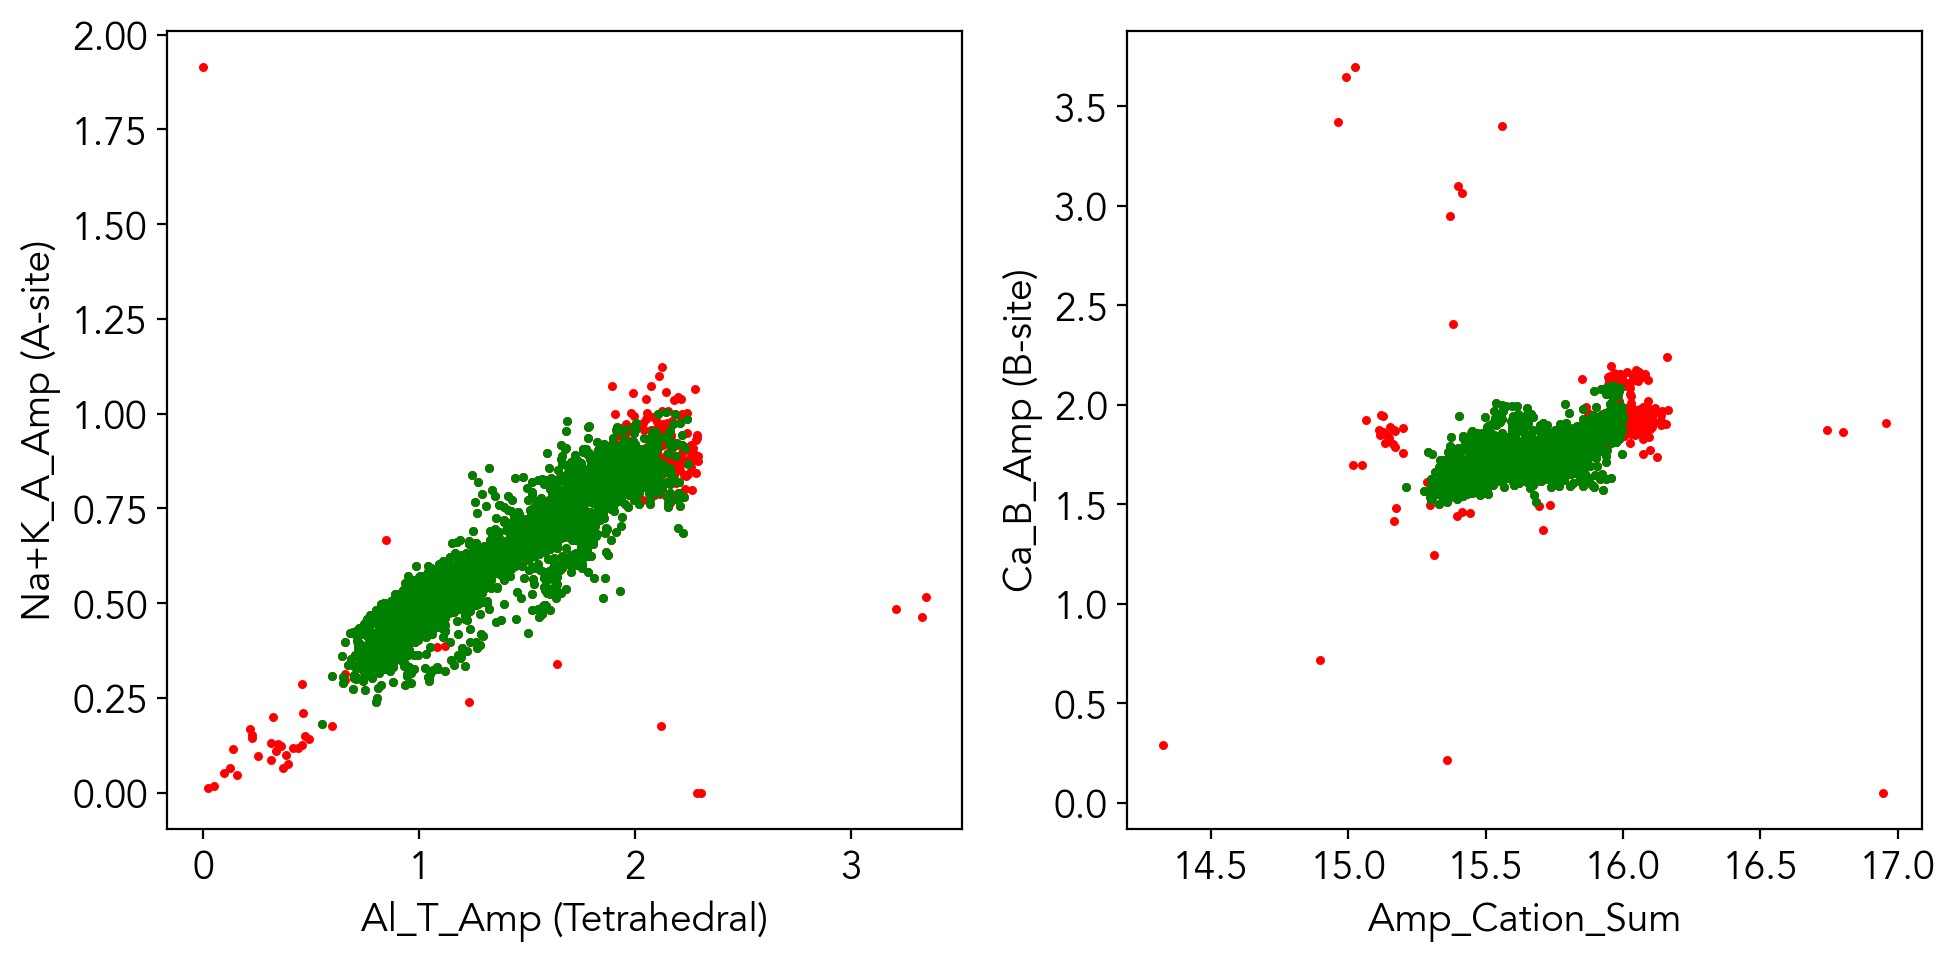

In [4]:
amp_df = min_df_lim[min_df_lim['Mineral'] == 'Amphibole'].rename(columns={c: c+'_Amp' for c in min_df_lim.columns if c not in constants })
amp_comp = mm.get_amp_sites_from_input_not_amp(amp_df, '_Amp')
amp_comp_filt = amp_comp.loc[((amp_comp['Amp_Cation_Sum'].between(15, 16)) & (amp_comp['Ca_B_Amp'].between(1.5, 2.1)) & (amp_comp['Al_T_Amp'].between(0.5, 2.25)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
# Blundy and Holland, 1990 plot A_site v. Al_IV and Al_VI v. Al_IV
ax[0].scatter(amp_comp['Al_T_Amp'], amp_comp['Na_K_A_Amp'], s = 5, color = 'r')
ax[0].scatter(amp_comp_filt['Al_T_Amp'], amp_comp_filt['Na_K_A_Amp'], s = 5, color = 'g')
ax[0].set_xlabel('Al_T_Amp (Tetrahedral)')
ax[0].set_ylabel('Na+K_A_Amp (A-site)')
ax[1].scatter(amp_comp['Amp_Cation_Sum'], amp_comp['Ca_B_Amp'], s = 5, color = 'r')
ax[1].scatter(amp_comp_filt['Amp_Cation_Sum'], amp_comp_filt['Ca_B_Amp'], s = 5, color = 'g')
ax[1].set_xlabel('Amp_Cation_Sum')
ax[1].set_ylabel('Ca_B_Amp (B-site)')
plt.tight_layout()

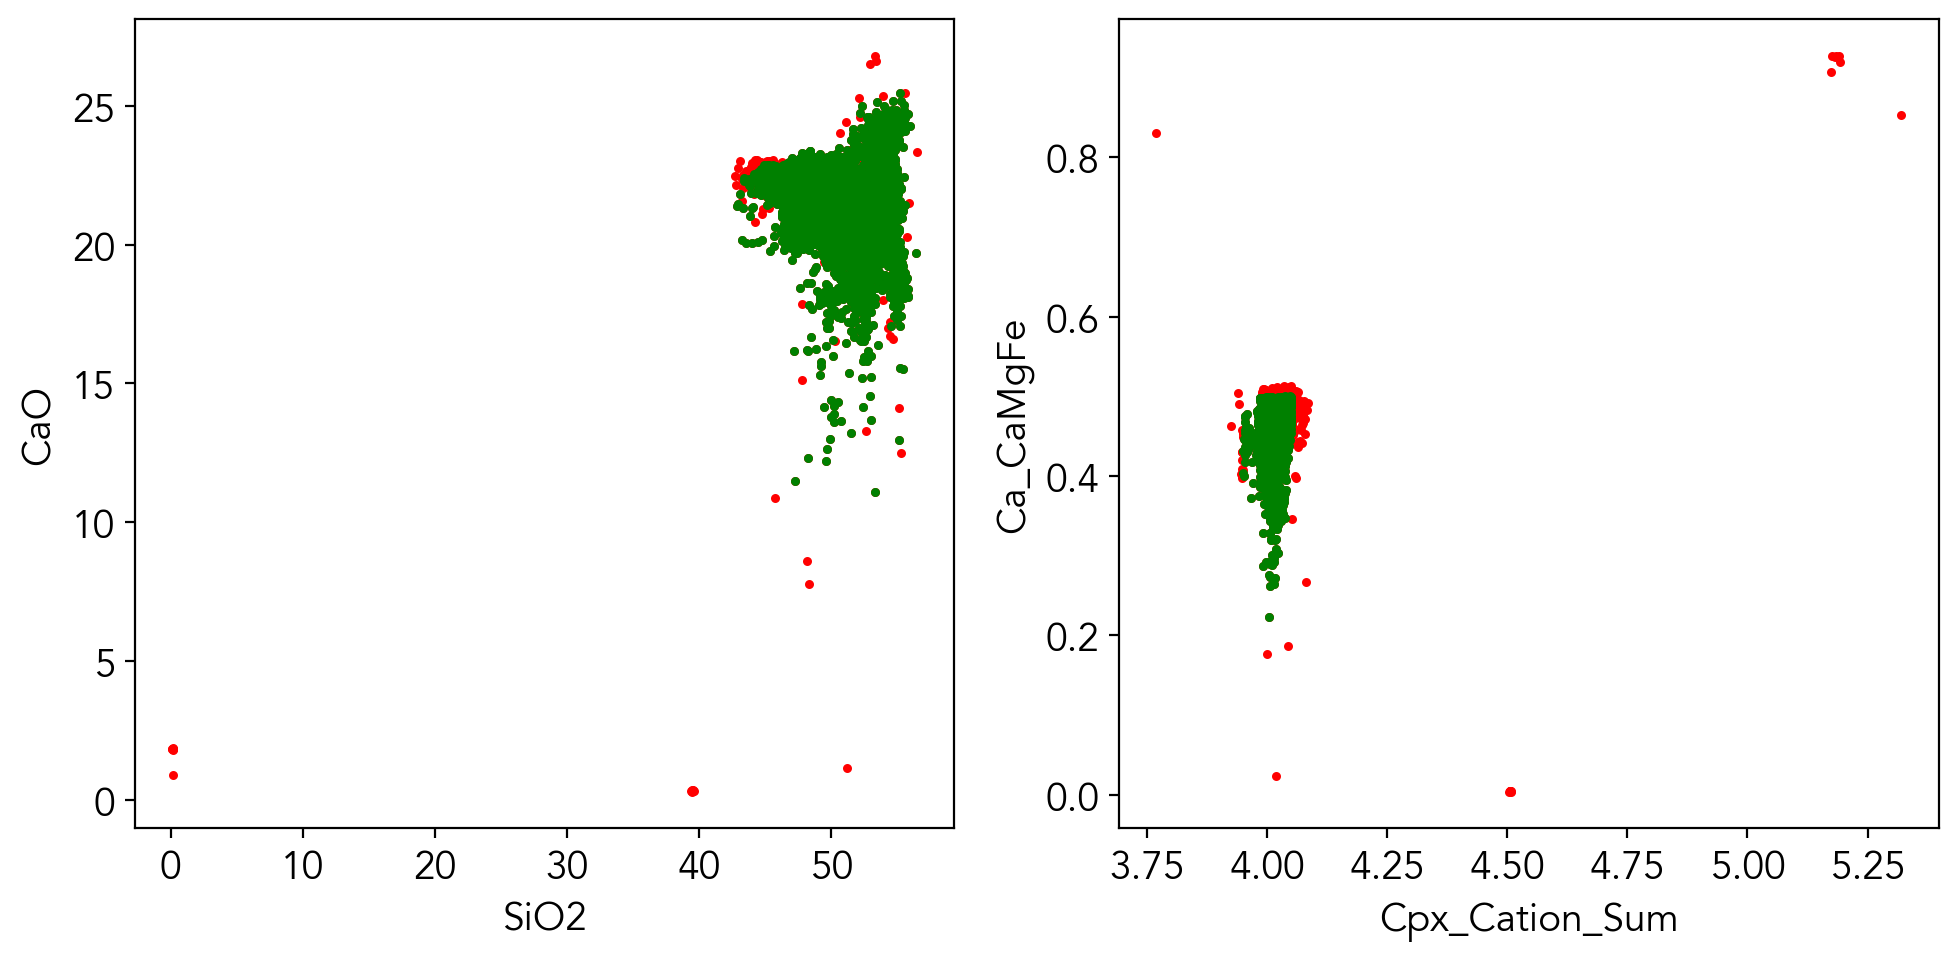

In [5]:
cpx_df = min_df_lim[min_df_lim['Mineral'] == 'Clinopyroxene'].rename(columns={c: c+'_Cpx' for c in min_df_lim.columns if c not in constants })
cpx_comp = mm.calculate_clinopyroxene_components(cpx_comps=cpx_df)
cpx_comp_filt = cpx_comp.loc[((cpx_comp.Cpx_Cation_Sum.between(3.95, 4.05)) & (cpx_comp.Ca_CaMgFe_Cpx.between(0.2, 0.5)) )]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(cpx_comp['SiO2_Cpx'], cpx_comp['CaO_Cpx'], s = 5, color = 'r')
ax[0].scatter(cpx_comp_filt['SiO2_Cpx'], cpx_comp_filt['CaO_Cpx'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('CaO')
ax[1].scatter(cpx_comp['Cpx_Cation_Sum'], cpx_comp['Ca_CaMgFe_Cpx'], s = 5, color = 'r')
ax[1].scatter(cpx_comp_filt['Cpx_Cation_Sum'], cpx_comp_filt['Ca_CaMgFe_Cpx'], s = 5, color = 'g')
ax[1].set_xlabel('Cpx_Cation_Sum')
ax[1].set_ylabel('Ca_CaMgFe')
plt.tight_layout()

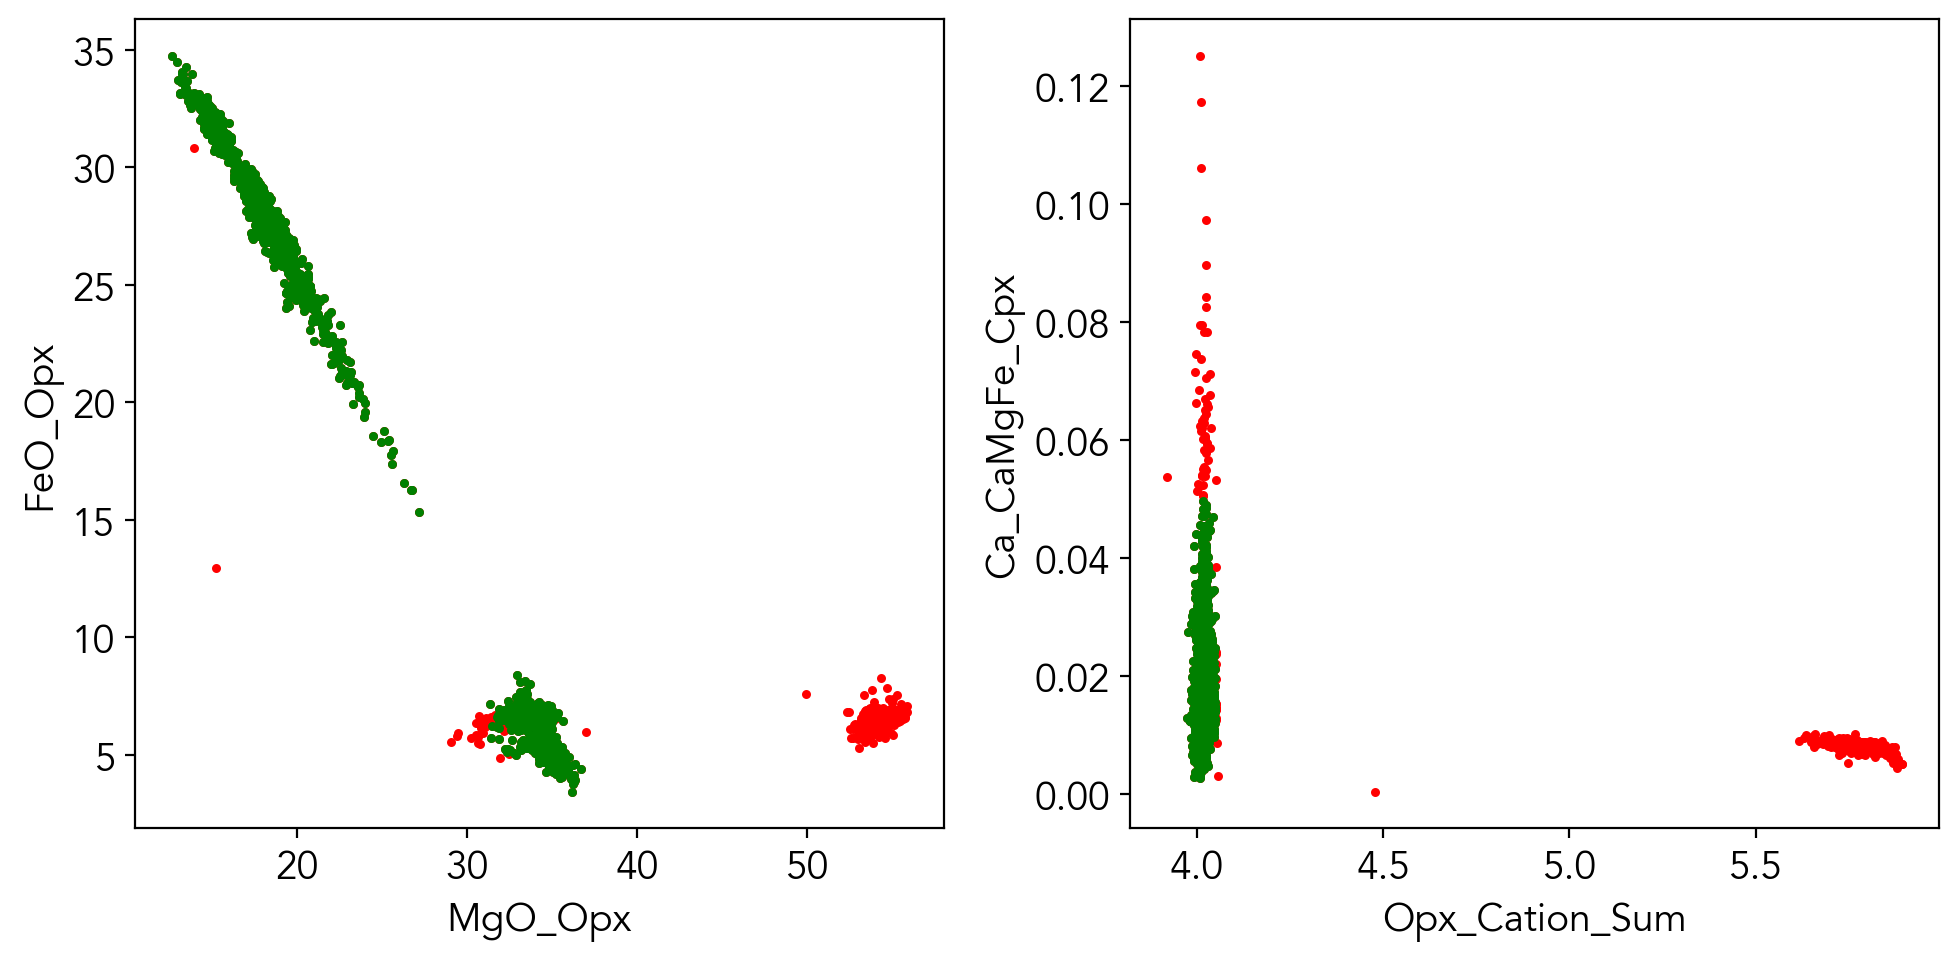

In [6]:
opx_df = min_df_lim[min_df_lim['Mineral'] == 'Orthopyroxene'].rename(columns={c: c+'_Opx' for c in min_df_lim.columns if c not in constants })
opx_comp = mm.calculate_orthopyroxene_components(opx_comps=opx_df)
opx_comp_filt = opx_comp.loc[((opx_comp.Opx_Cation_Sum.between(3.95, 4.05)) & (opx_comp.Ca_CaMgFe_Opx.between(-0.01, 0.05)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(opx_comp['MgO_Opx'], opx_comp['FeOt_Opx'], s = 5, color = 'r')
ax[0].scatter(opx_comp_filt['MgO_Opx'], opx_comp_filt['FeOt_Opx'], s = 5, color = 'g')
ax[0].set_xlabel('MgO_Opx')
ax[0].set_ylabel('FeO_Opx')
ax[1].scatter(opx_comp['Opx_Cation_Sum'], opx_comp['Ca_CaMgFe_Opx'], s = 5, color = 'r')
ax[1].scatter(opx_comp_filt['Opx_Cation_Sum'], opx_comp_filt['Ca_CaMgFe_Opx'], s = 5, color = 'g')
ax[1].set_xlabel('Opx_Cation_Sum')
ax[1].set_ylabel('Ca_CaMgFe_Cpx')
plt.tight_layout()

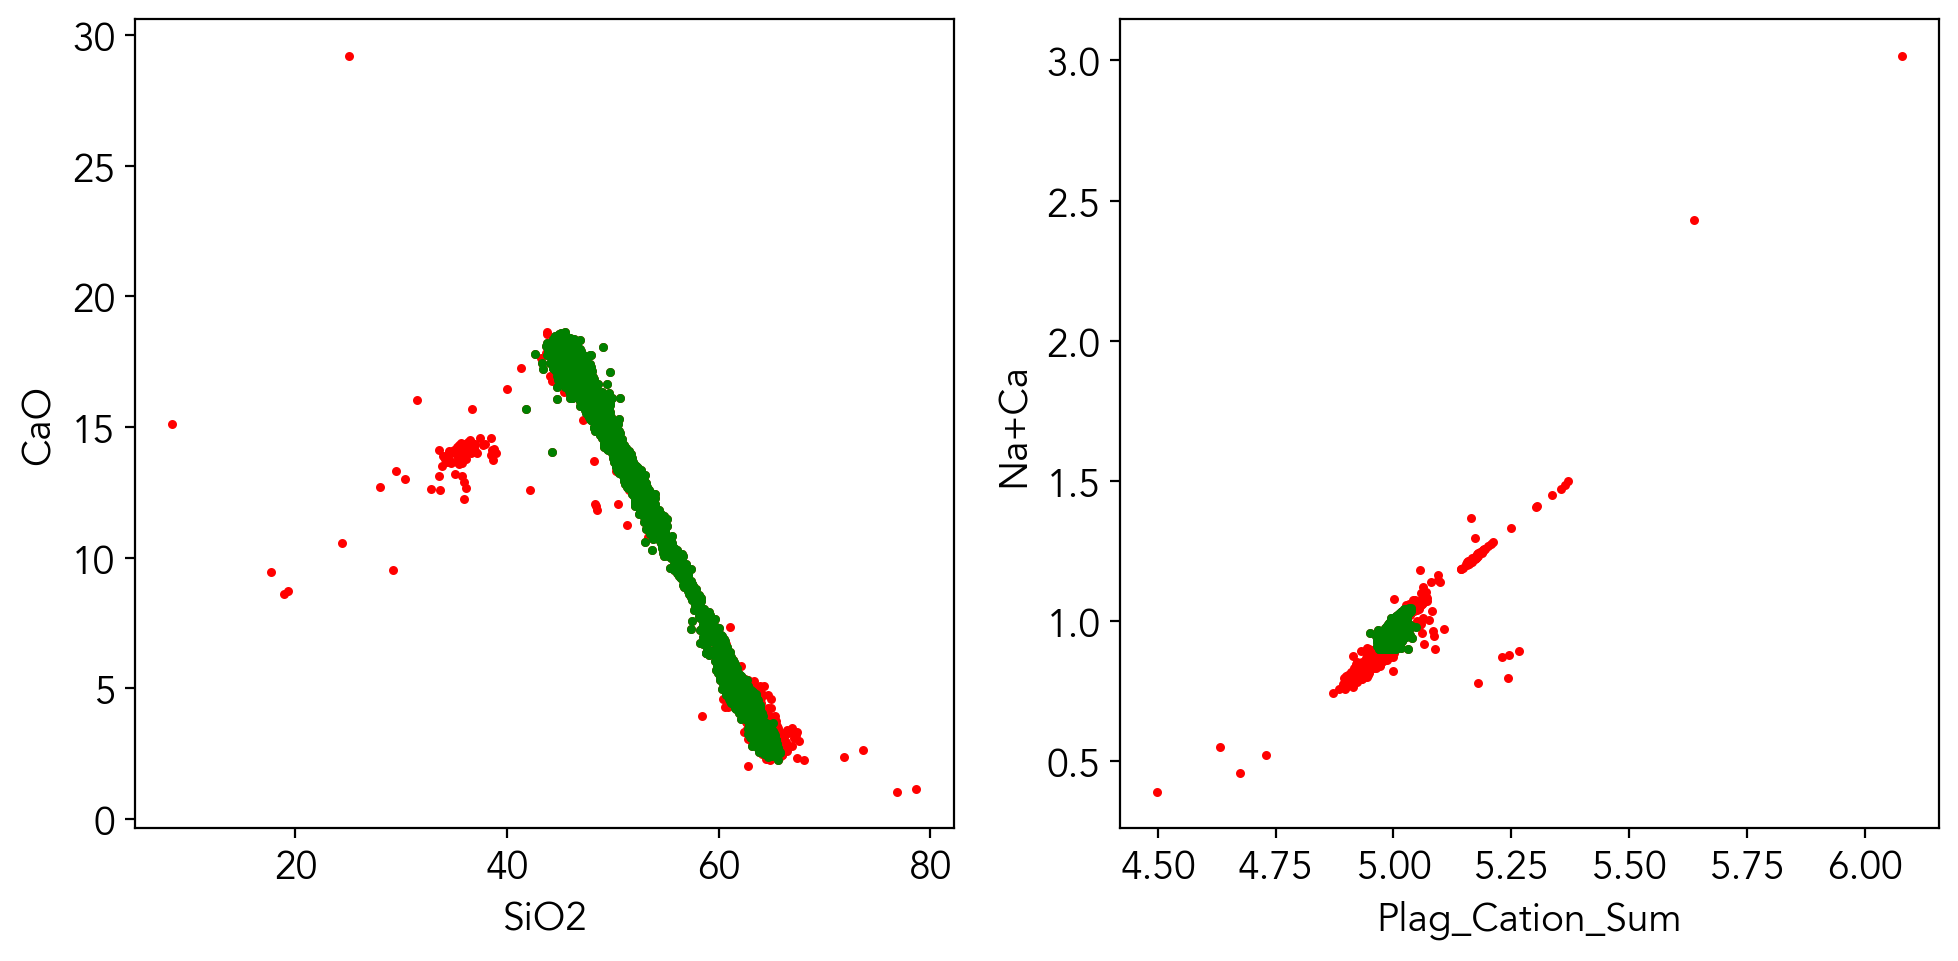

In [7]:
plag_df = min_df_lim[min_df_lim['Mineral'] == 'Plagioclase'].rename(columns={c: c+'_Plag' for c in min_df_lim.columns if c not in constants })
plag_comp = mm.calculate_plagioclase_components(plag_df, '_Plag')
plag_comp_filt = plag_comp.loc[((plag_comp.Plag_Cation_Sum.between(4.95, 5.05)) & (plag_comp.Na_Ca_M_Plag.between(0.9, 1.05)) & (plag_comp.SiO2_Plag.between(40, 70)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(plag_comp['SiO2_Plag'], plag_comp['CaO_Plag'], s = 5, color = 'r')
ax[0].scatter(plag_comp_filt['SiO2_Plag'], plag_comp_filt['CaO_Plag'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('CaO')
ax[1].scatter(plag_comp['Plag_Cation_Sum'], plag_comp['Na_Ca_M_Plag'], s = 5, color = 'r')
ax[1].scatter(plag_comp_filt['Plag_Cation_Sum'], plag_comp_filt['Na_Ca_M_Plag'], s = 5, color = 'g')
ax[1].set_xlabel('Plag_Cation_Sum')
ax[1].set_ylabel('Na+Ca')
plt.tight_layout()

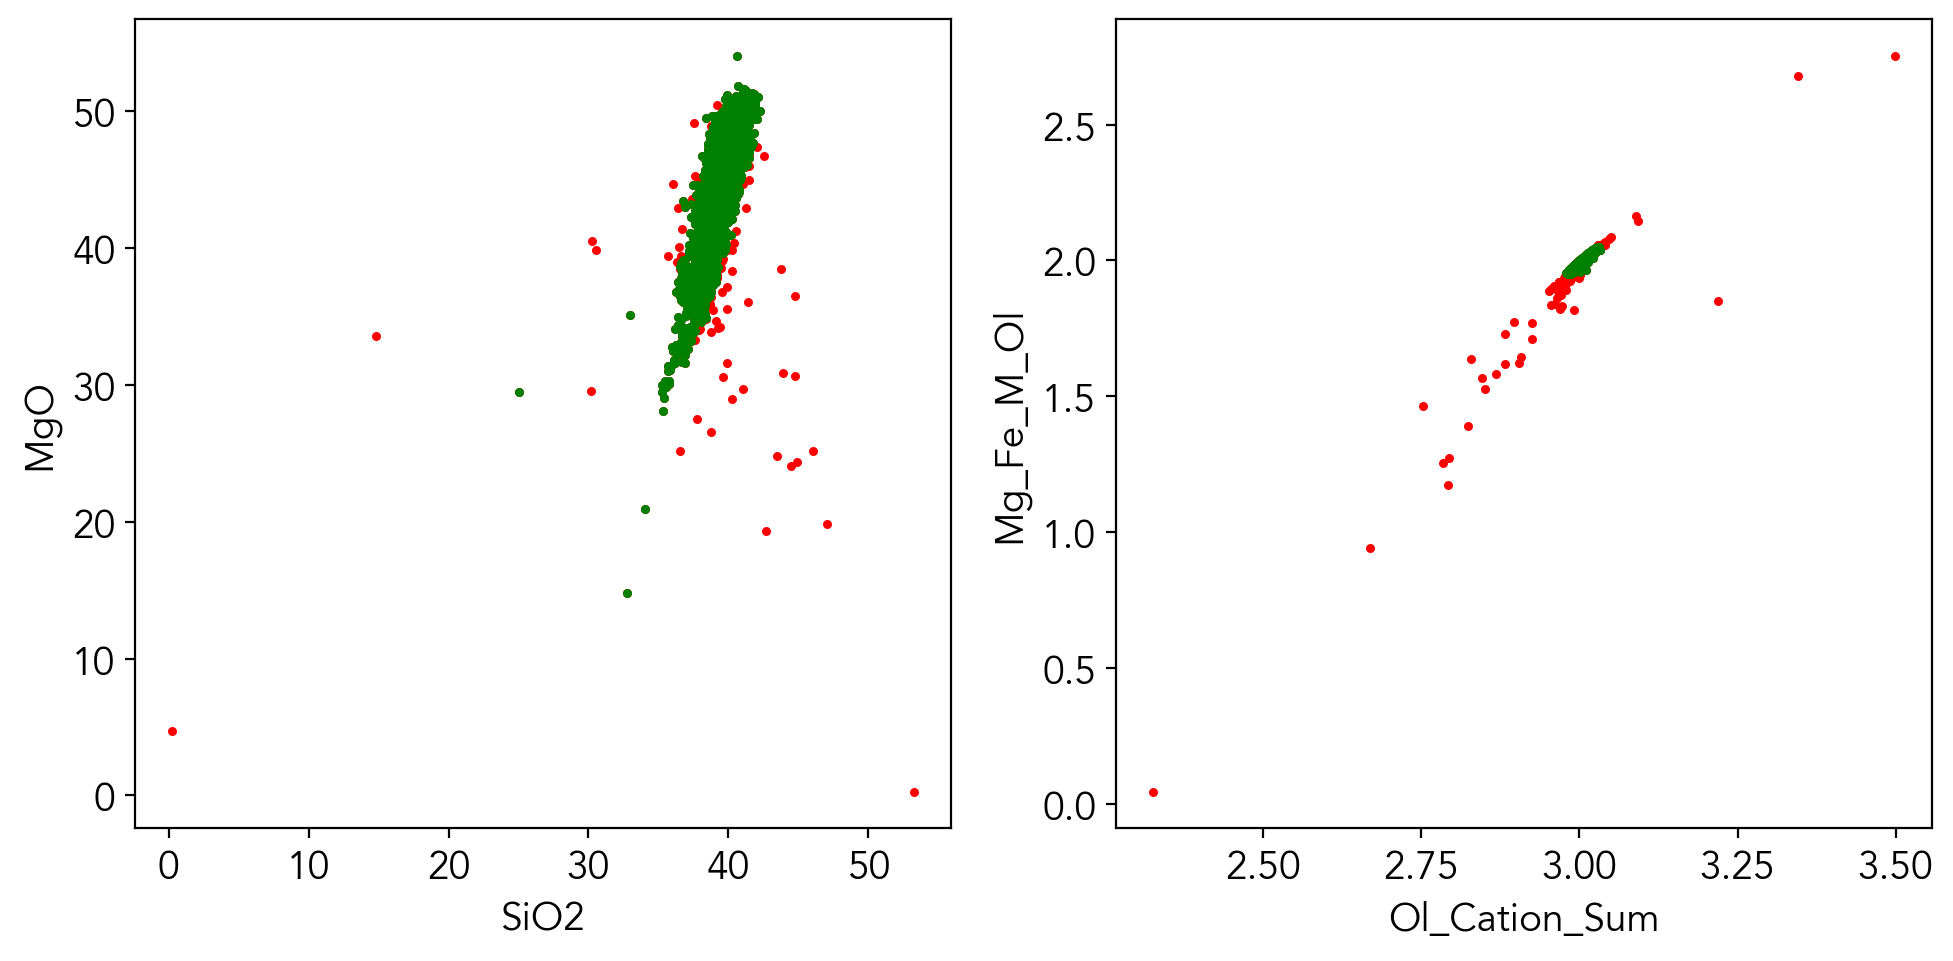

In [8]:
ol_df = min_df_lim[min_df_lim['Mineral'] == 'Olivine'].rename(columns={c: c+'_Ol' for c in min_df_lim.columns if c not in constants })
ol_comp = mm.calculate_olivine_components(ol_df, '_Ol')
ol_comp_filt = ol_comp.loc[( (ol_comp.Ol_Cation_Sum.between(2.95, 3.05)) & (ol_comp.Mg_Fe_M_Ol.between(1.95, 2.05) )) ]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(ol_comp['SiO2_Ol'], ol_comp['MgO_Ol'], s = 5, color = 'r')
ax[0].scatter(ol_comp_filt['SiO2_Ol'], ol_comp_filt['MgO_Ol'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('MgO')
ax[1].scatter(ol_comp['Ol_Cation_Sum'], ol_comp['Mg_Fe_M_Ol'], s = 5, color = 'r')
ax[1].scatter(ol_comp_filt['Ol_Cation_Sum'], ol_comp_filt['Mg_Fe_M_Ol'], s = 5, color = 'g')
ax[1].set_xlabel('Ol_Cation_Sum')
ax[1].set_ylabel('Mg_Fe_M_Ol')
plt.tight_layout()

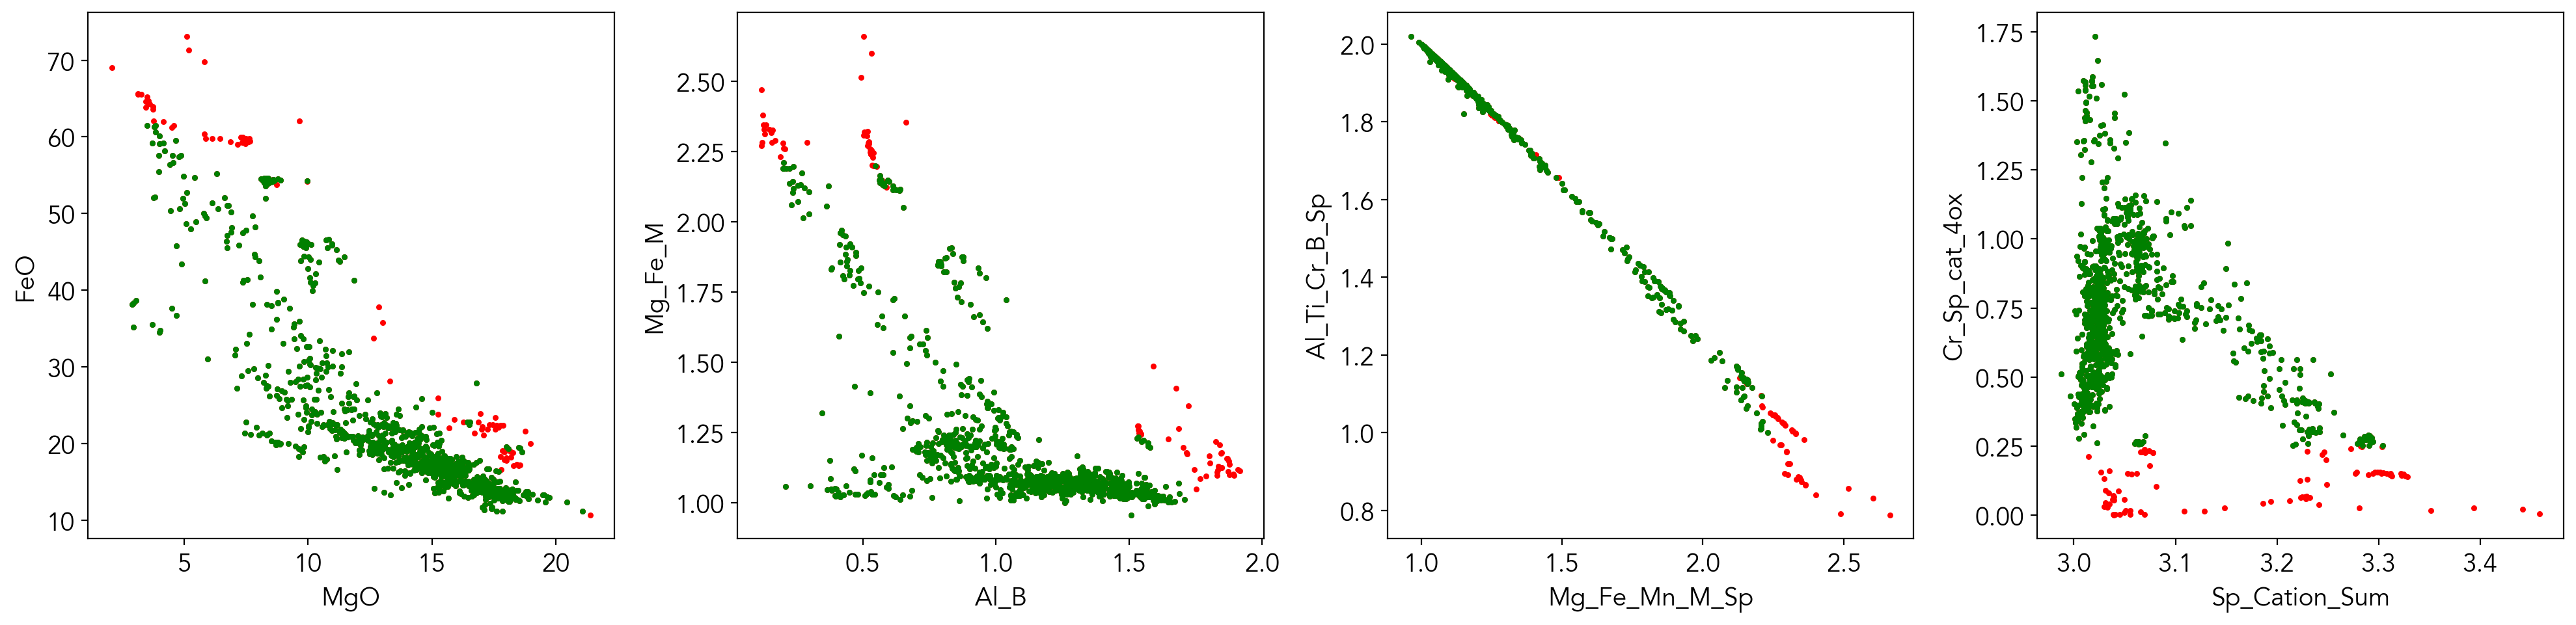

In [9]:
sp_df = min_df_lim[min_df_lim['Mineral'] == 'Spinel'].rename(columns={c: c+'_Sp' for c in min_df_lim.columns if c not in constants })
sp_comp = mm.calculate_spinel_components(sp_df, '_Sp')
sp_comp_filt = sp_comp.loc[( (sp_comp.Sp_Cation_Sum.between(2.95, 3.45)) & (sp_comp.Al_Ti_Cr_B_Sp.between(0.75, 2.05)) &  (sp_comp.Cr_Sp_cat_4ox.between(0.25, 1.75)) )]

fig, ax = plt.subplots(1, 4, figsize = (20, 5))
ax = ax.flatten()
ax[0].scatter(sp_comp['MgO_Sp'], sp_comp['FeOt_Sp'], s = 5, color = 'r')
ax[0].scatter(sp_comp_filt['MgO_Sp'], sp_comp_filt['FeOt_Sp'], s = 5, color = 'g')
ax[0].set_xlabel('MgO')
ax[0].set_ylabel('FeO')
ax[1].scatter(sp_comp['Al_B_Sp'], sp_comp['Mg_Fe_M_Sp'], s = 5, color = 'r')
ax[1].scatter(sp_comp_filt['Al_B_Sp'], sp_comp_filt['Mg_Fe_M_Sp'], s = 5, color = 'g')
ax[1].set_xlabel('Al_B')
ax[1].set_ylabel('Mg_Fe_M')
ax[2].scatter(sp_comp['Mg_Fe_Mn_M_Sp'], sp_comp['Al_Ti_Cr_B_Sp'], s = 5, color = 'r')
ax[2].scatter(sp_comp_filt['Mg_Fe_Mn_M_Sp'], sp_comp_filt['Al_Ti_Cr_B_Sp'], s = 5, color = 'g')
ax[2].set_xlabel('Mg_Fe_Mn_M_Sp')
ax[2].set_ylabel('Al_Ti_Cr_B_Sp')
ax[3].scatter(sp_comp['Sp_Cation_Sum'], sp_comp['Cr_Sp_cat_4ox'], s = 5, color = 'r')
ax[3].scatter(sp_comp_filt['Sp_Cation_Sum'], sp_comp_filt['Cr_Sp_cat_4ox'], s = 5, color = 'g')
ax[3].set_xlabel('Sp_Cation_Sum')
ax[3].set_ylabel('Cr_Sp_cat_4ox')
plt.tight_layout()

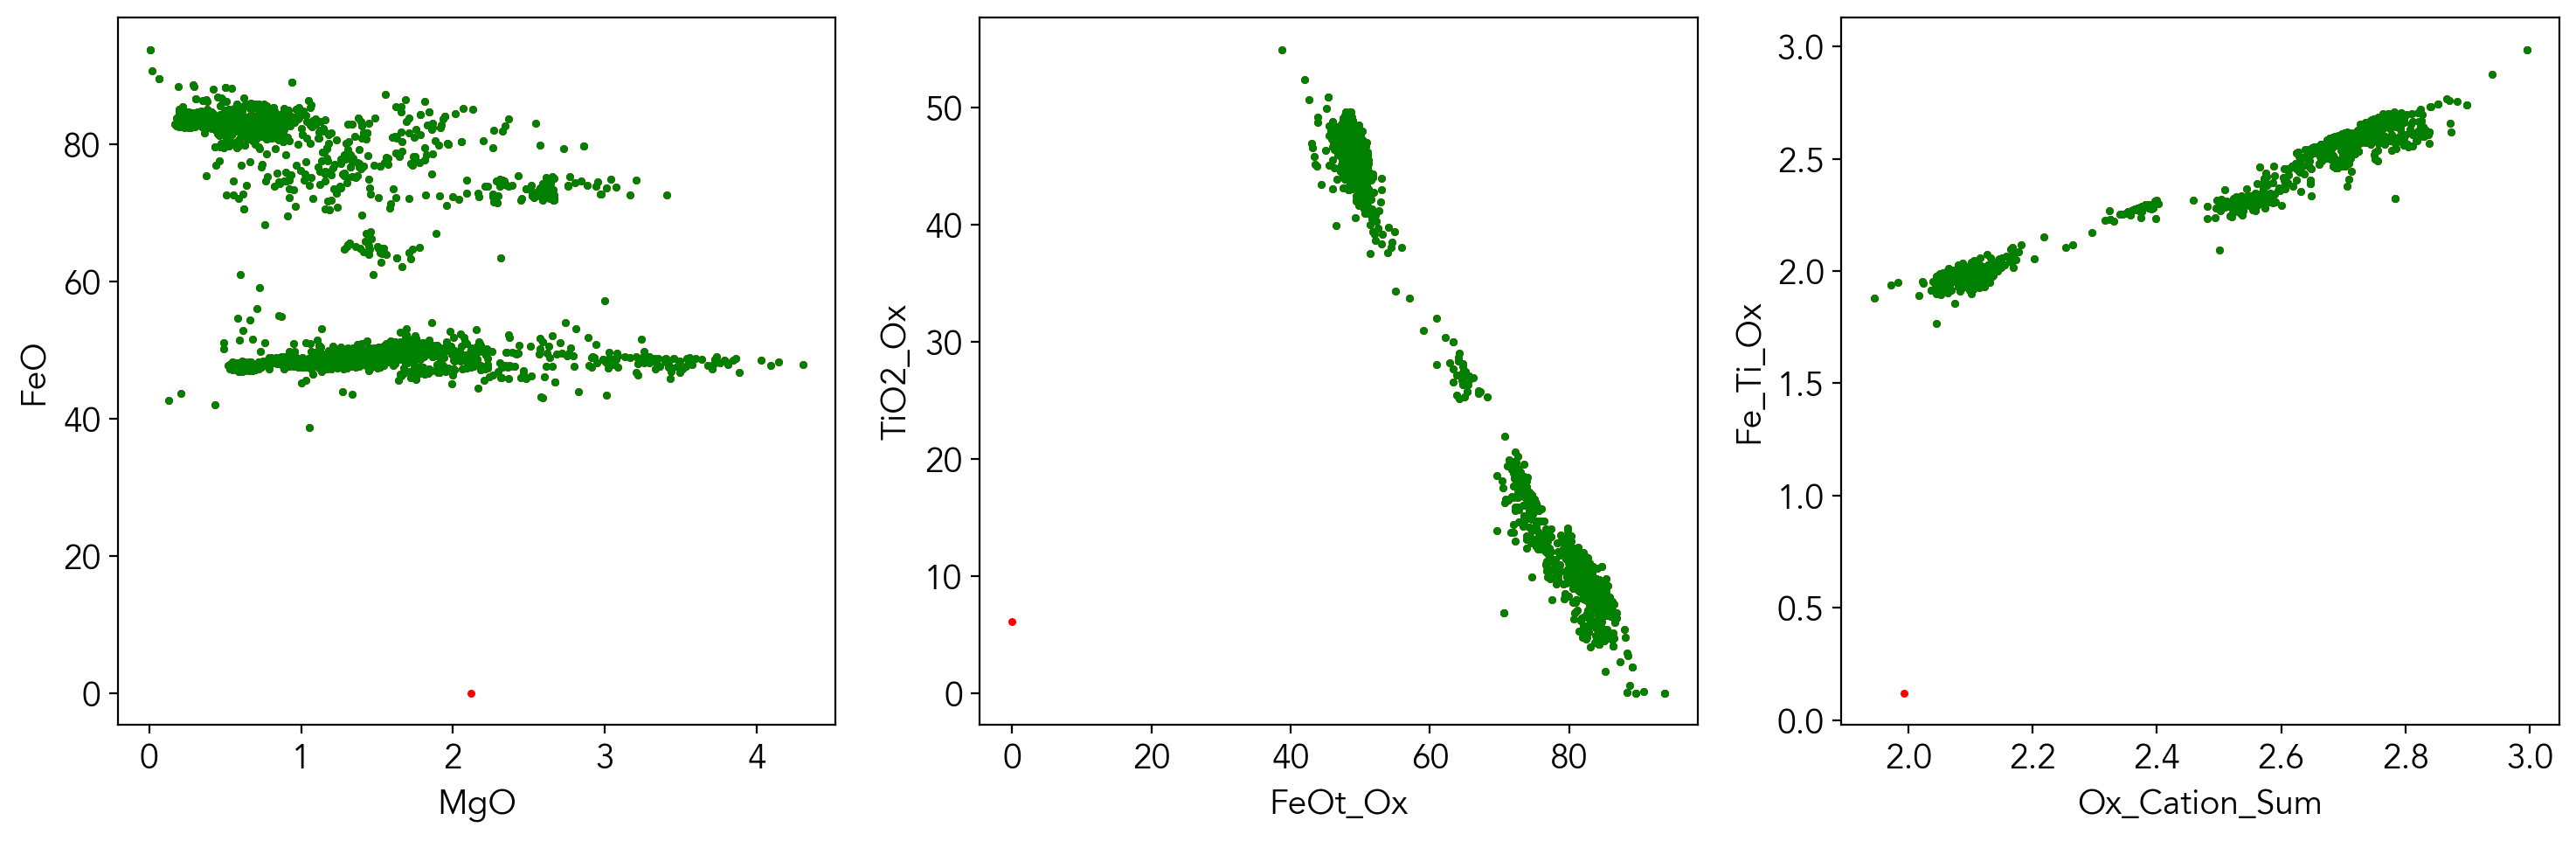

In [10]:
ox_df = min_df_lim[min_df_lim['Mineral'] == 'FeTiOxide'].rename(columns={c: c+'_Ox' for c in min_df_lim.columns if c not in constants })
ox_comp = mm.calculate_oxide_components(ox_df, '_Ox')
ox_comp_filt = ox_comp.loc[((ox_comp.Fe_Ti_Ox.between(1.5, 3.0)))]

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
ax[0].scatter(ox_comp['MgO_Ox'], ox_comp['FeOt_Ox'], s = 5, color = 'r')
ax[0].scatter(ox_comp_filt['MgO_Ox'], ox_comp_filt['FeOt_Ox'], s = 5, color = 'g')
ax[0].set_xlabel('MgO')
ax[0].set_ylabel('FeO')
ax[1].scatter(ox_comp['FeOt_Ox'], ox_comp['TiO2_Ox'], s = 5, color = 'r')
ax[1].scatter(ox_comp_filt['FeOt_Ox'], ox_comp_filt['TiO2_Ox'], s = 5, color = 'g')
ax[1].set_xlabel('FeOt_Ox')
ax[1].set_ylabel('TiO2_Ox')
ax[2].scatter(ox_comp['Ox_Cation_Sum'], ox_comp['Fe_Ti_Ox'], s = 5, color = 'r')
ax[2].scatter(ox_comp_filt['Ox_Cation_Sum'], ox_comp_filt['Fe_Ti_Ox'], s = 5, color = 'g')
ax[2].set_xlabel('Ox_Cation_Sum')
ax[2].set_ylabel('Fe_Ti_Ox')
plt.tight_layout()

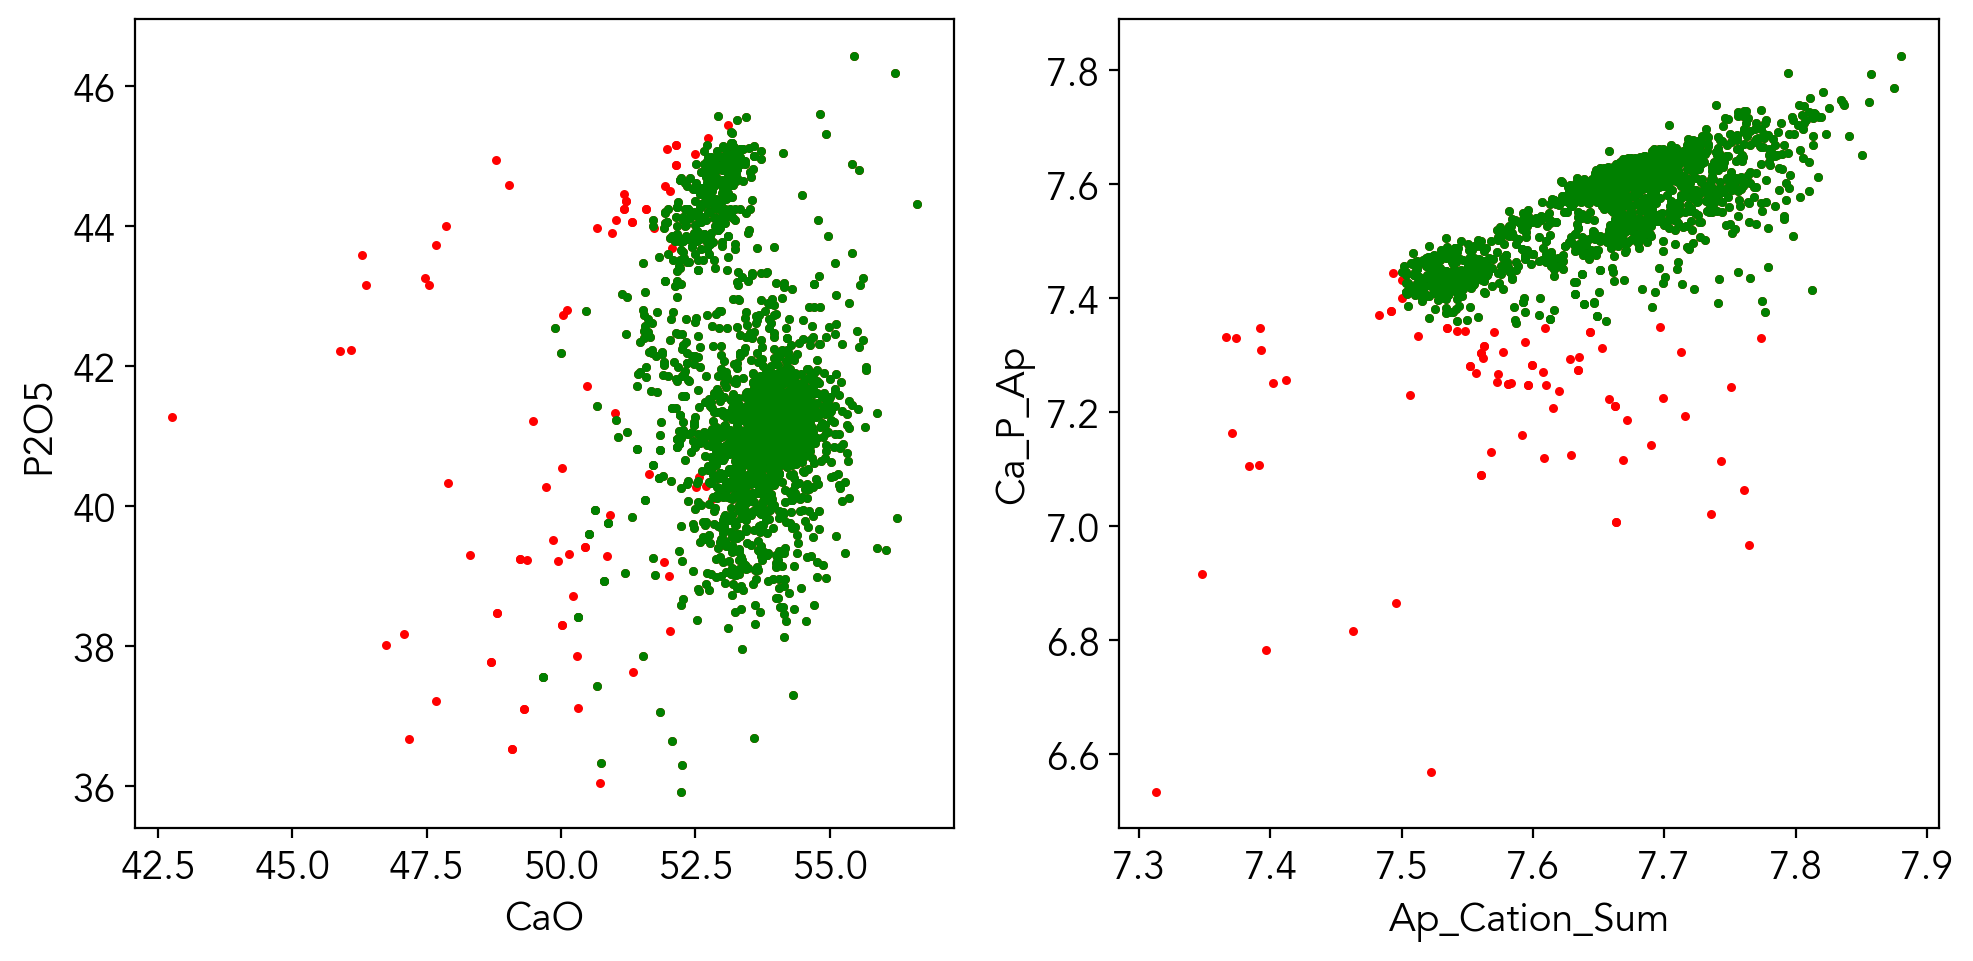

In [11]:
ap_df = min_df_lim[min_df_lim['Mineral'] == 'Apatite'].rename(columns={c: c+'_Ap' for c in min_df_lim.columns if c not in constants })
ap_comp = mm.calculate_apatite_components(ap_df, '_Ap')
ap_comp_filt = ap_comp.loc[((ap_comp.Ap_Cation_Sum.between(7.5, 8.0)) & (ap_comp.Ca_P_Ap.between(7.35, 8.00)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(ap_comp['CaO_Ap'], ap_comp['P2O5_Ap'], s = 5, color = 'r')
ax[0].scatter(ap_comp_filt['CaO_Ap'], ap_comp_filt['P2O5_Ap'], s = 5, color = 'g')
ax[0].set_xlabel('CaO')
ax[0].set_ylabel('P2O5')
ax[1].scatter(ap_comp['Ap_Cation_Sum'], ap_comp['Ca_P_Ap'], s = 5, color = 'r')
ax[1].scatter(ap_comp_filt['Ap_Cation_Sum'], ap_comp_filt['Ca_P_Ap'], s = 5, color = 'g')
ax[1].set_xlabel('Ap_Cation_Sum')
ax[1].set_ylabel('Ca_P_Ap')
plt.tight_layout()

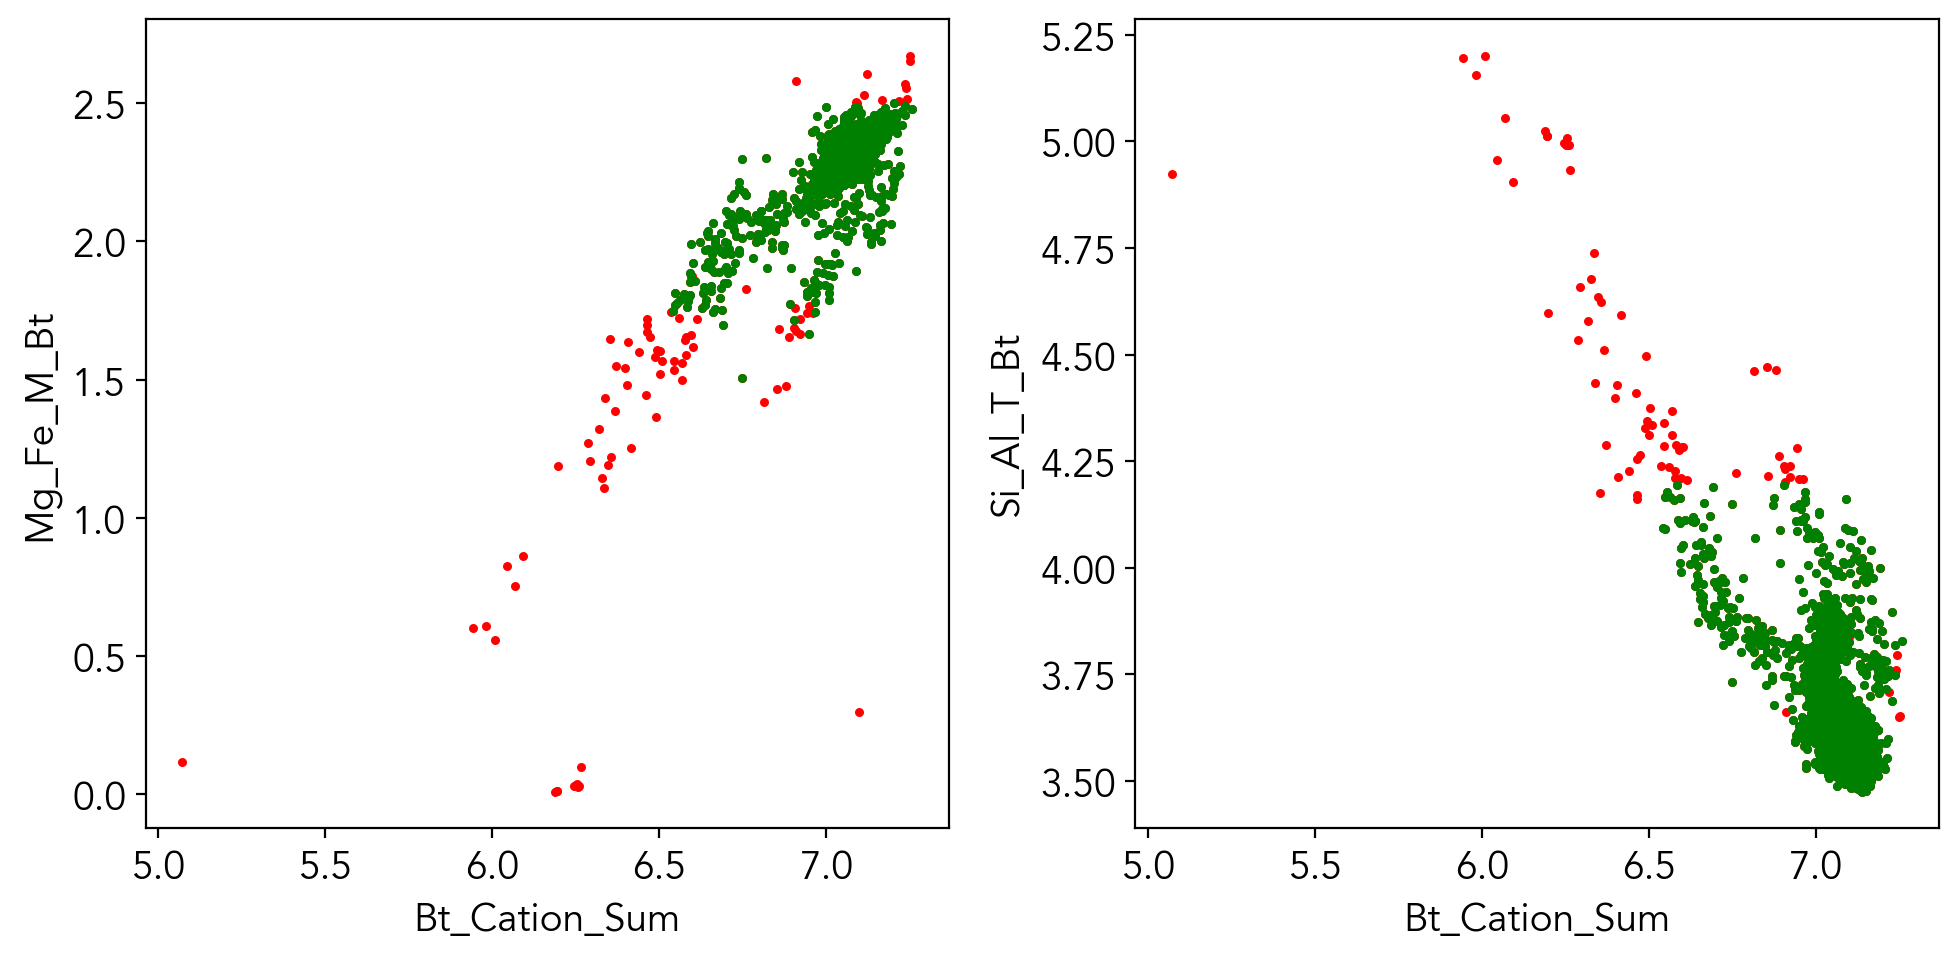

In [12]:
bt_df = min_df_lim[min_df_lim['Mineral'] == 'Biotite'].rename(columns={c: c+'_Bt' for c in min_df_lim.columns if c not in constants })
bt_comp = mm.calculate_biotite_components(bt_df, '_Bt')
bt_comp_filt = bt_comp.loc[((bt_comp.Bt_Cation_Sum.between(6.5, 7.5)) & (bt_comp.Mg_Fe_M_Bt.between(1.5, 2.5)) & (bt_comp.Si_Al_T_Bt.between(3.4, 4.2)) )]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(bt_comp['Bt_Cation_Sum'], bt_comp['Mg_Fe_M_Bt'], s = 5, color = 'r')
ax[0].scatter(bt_comp_filt['Bt_Cation_Sum'], bt_comp_filt['Mg_Fe_M_Bt'], s = 5, color = 'g')
ax[0].set_xlabel('Bt_Cation_Sum')
ax[0].set_ylabel('Mg_Fe_M_Bt')
ax[1].scatter(bt_comp['Bt_Cation_Sum'], bt_comp['Si_Al_T_Bt'], s = 5, color = 'r')
ax[1].scatter(bt_comp_filt['Bt_Cation_Sum'], bt_comp_filt['Si_Al_T_Bt'], s = 5, color = 'g')
ax[1].set_xlabel('Bt_Cation_Sum')
ax[1].set_ylabel('Si_Al_T_Bt')
plt.tight_layout()

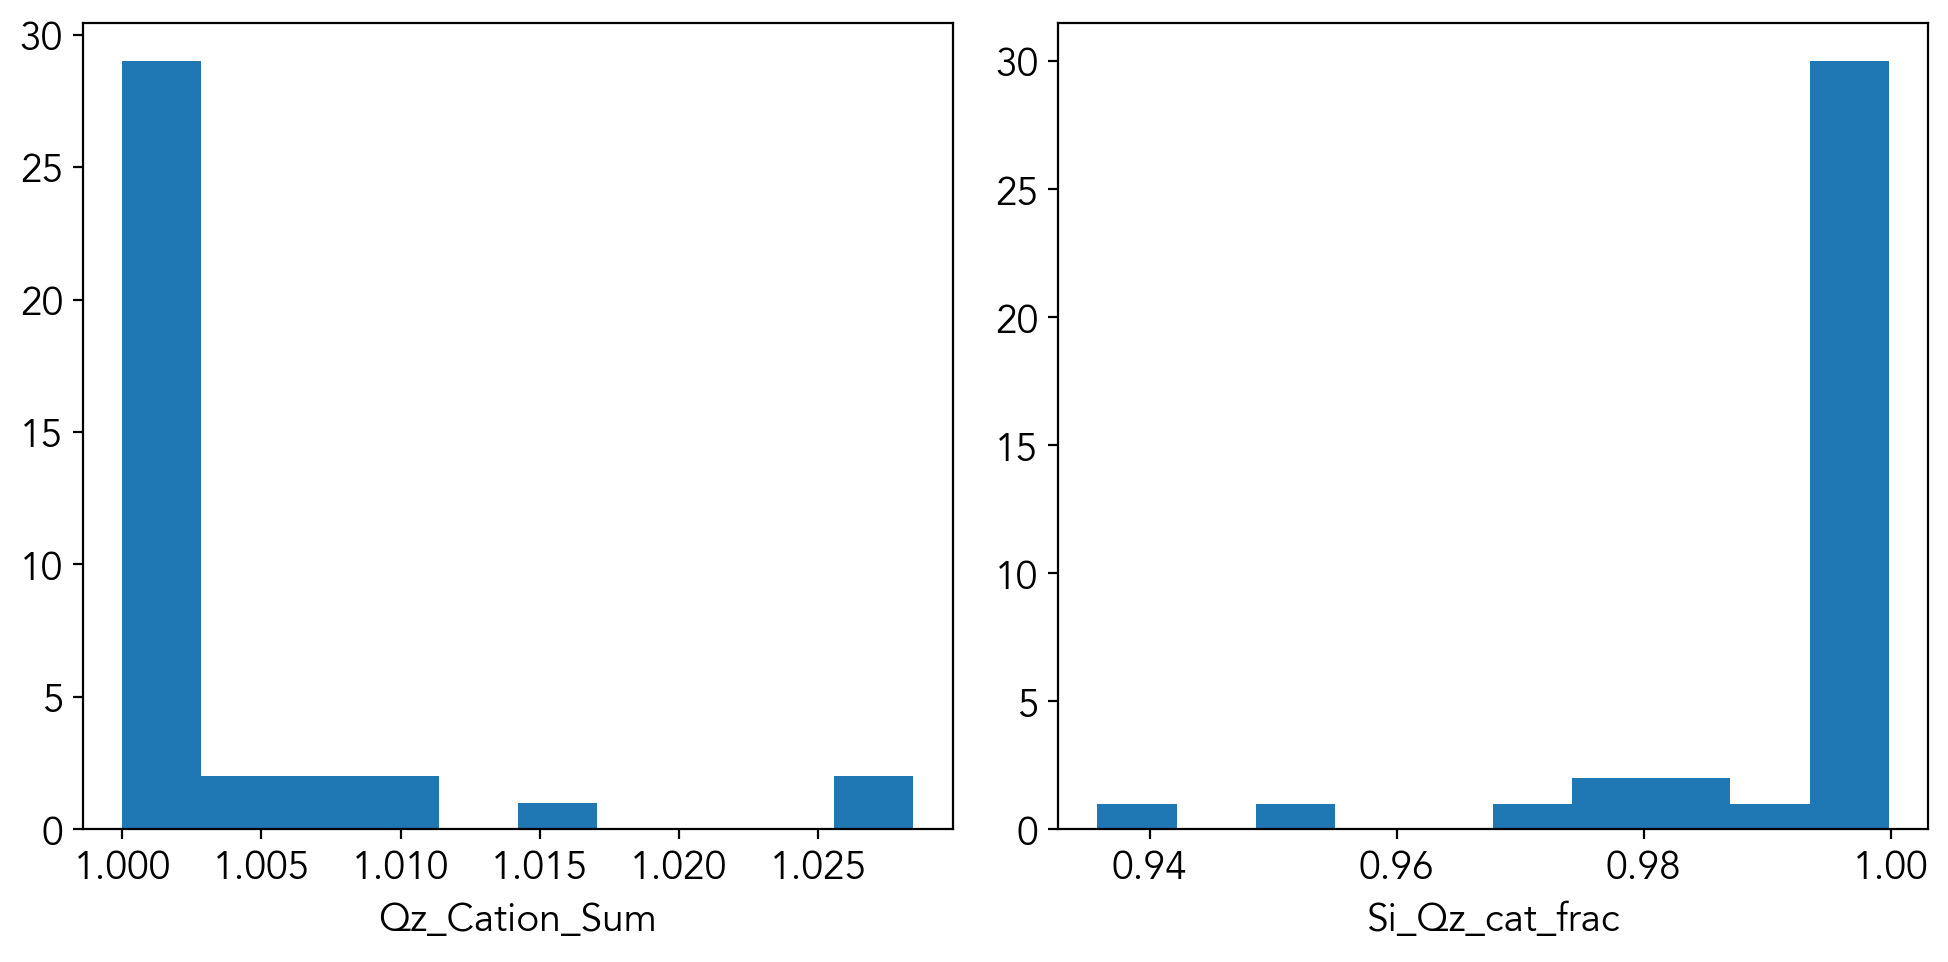

In [13]:
qz_df = min_df_lim[min_df_lim['Mineral'] == 'Quartz'].rename(columns={c: c+'_Qz' for c in min_df_lim.columns if c not in constants })
qz_comp = mm.calculate_quartz_components(qz_df, '_Qz')
qz_comp_filt = qz_comp.copy()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].hist(qz_comp['Qz_Cation_Sum'], bins = 10)
ax[0].set_xlabel('Qz_Cation_Sum')
ax[1].hist(qz_comp['Si_Qz_cat_frac'], bins = 10)
ax[1].set_xlabel('Si_Qz_cat_frac')
plt.tight_layout()

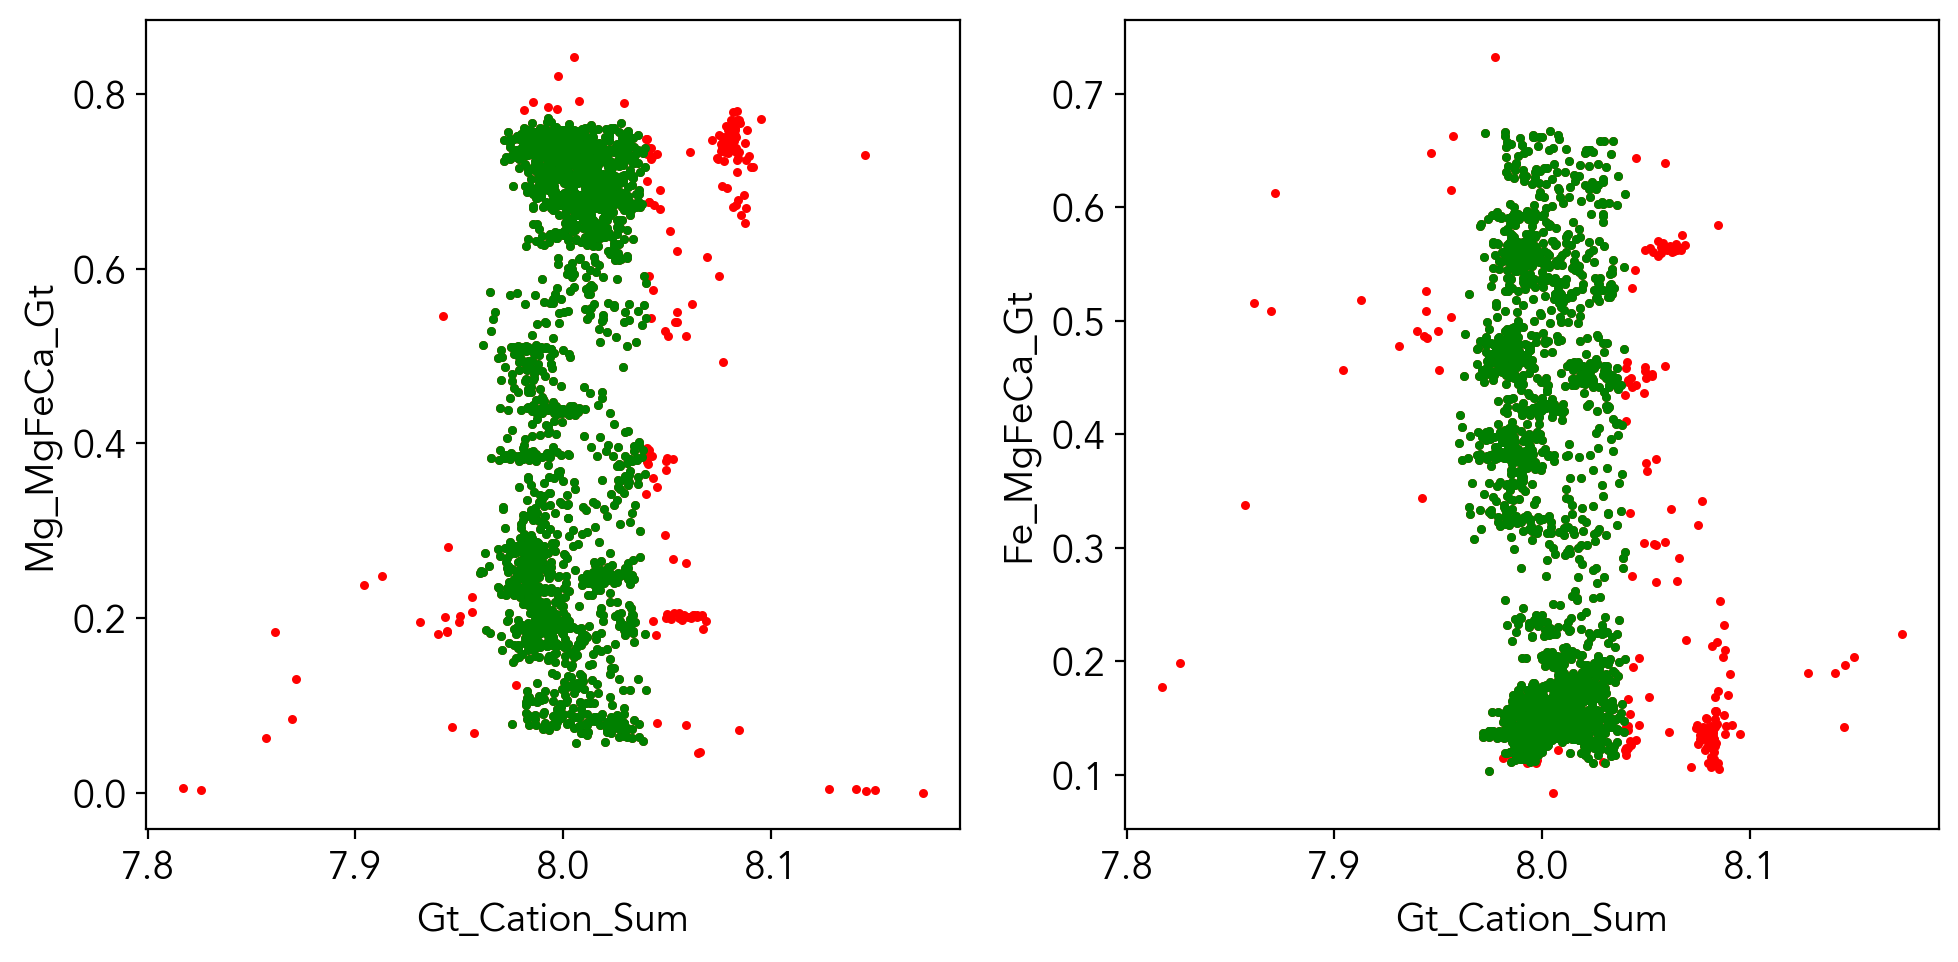

In [14]:
gt_df = min_df_lim[min_df_lim['Mineral'] == 'Garnet'].rename(columns={c: c+'_Gt' for c in min_df_lim.columns if c not in constants })
gt_comp = mm.calculate_garnet_components(gt_df, '_Gt')
gt_comp_filt = gt_comp.loc[((gt_comp.Gt_Cation_Sum.between(7.96, 8.04)) & (gt_comp.Mg_MgFeCa_Gt.between(0.05, 0.775)) & (gt_comp.Fe_MgFeCa_Gt.between(0.1, 0.7)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(gt_comp['Gt_Cation_Sum'], gt_comp['Mg_MgFeCa_Gt'], s = 5, color = 'r')
ax[0].scatter(gt_comp_filt['Gt_Cation_Sum'], gt_comp_filt['Mg_MgFeCa_Gt'], s = 5, color = 'g')
ax[0].set_xlabel('Gt_Cation_Sum')
ax[0].set_ylabel('Mg_MgFeCa_Gt')
ax[1].scatter(gt_comp['Gt_Cation_Sum'], gt_comp['Fe_MgFeCa_Gt'], s = 5, color = 'r')
ax[1].scatter(gt_comp_filt['Gt_Cation_Sum'], gt_comp_filt['Fe_MgFeCa_Gt'], s = 5, color = 'g')
ax[1].set_xlabel('Gt_Cation_Sum')
ax[1].set_ylabel('Fe_MgFeCa_Gt')
plt.tight_layout()

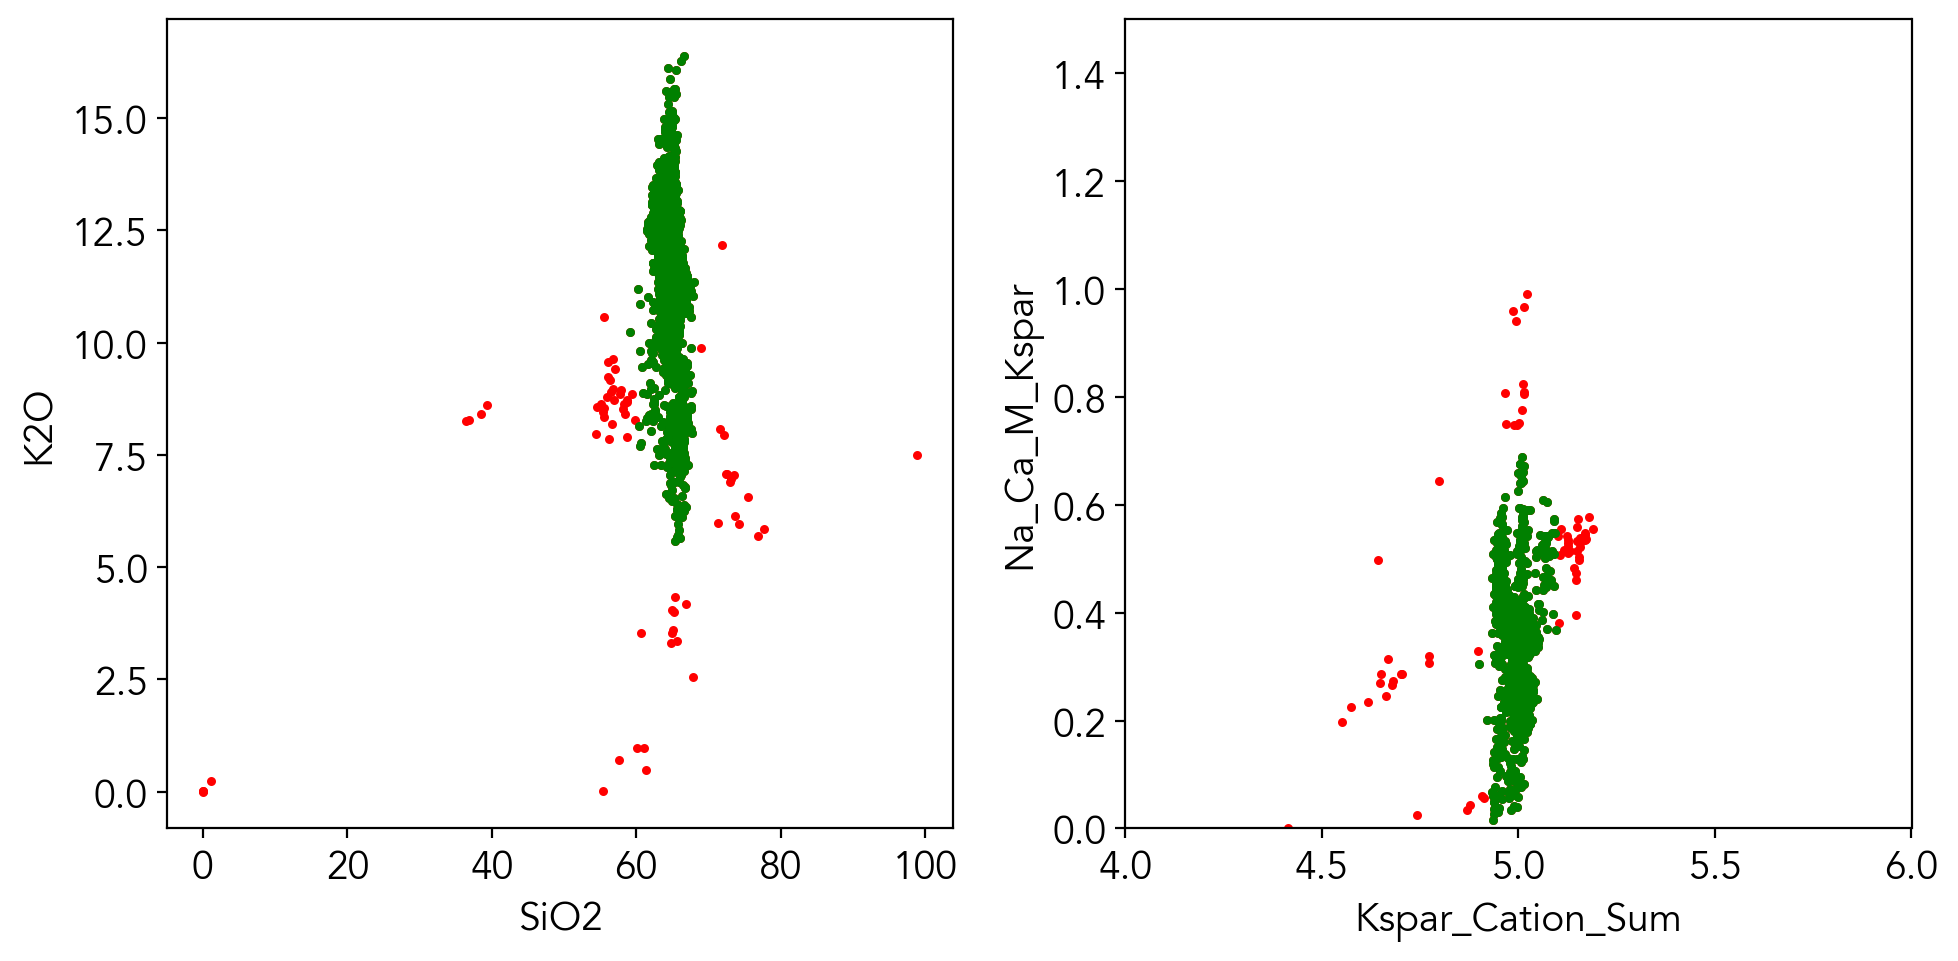

In [15]:
ksp_df = min_df_lim[min_df_lim['Mineral'] == 'KFeldspar'].rename(columns={c: c+'_Kspar' for c in min_df_lim.columns if c not in constants })
ksp_comp = mm.calculate_kspar_components(ksp_df, '_Kspar')

ksp_comp_filt = ksp_comp.loc[((ksp_comp.Kspar_Cation_Sum.between(4.9, 5.1)) & (ksp_comp.SiO2_Kspar.between(40, 80)) & (ksp_comp.K2O_Kspar.between(5, 17)) )]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(ksp_comp['SiO2_Kspar'], ksp_comp['K2O_Kspar'], s = 5, color = 'r')
ax[0].scatter(ksp_comp_filt['SiO2_Kspar'], ksp_comp_filt['K2O_Kspar'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('K2O')
ax[1].scatter(ksp_comp['Kspar_Cation_Sum'], ksp_comp['Na_Ca_M_Kspar'], s = 5, color = 'r')
ax[1].scatter(ksp_comp_filt['Kspar_Cation_Sum'], ksp_comp_filt['Na_Ca_M_Kspar'], s = 5, color = 'g')
ax[1].set_xlabel('Kspar_Cation_Sum')
ax[1].set_ylabel('Na_Ca_M_Kspar')
ax[1].set_xlim([4, 6])
ax[1].set_ylim([0, 1.5])
plt.tight_layout()

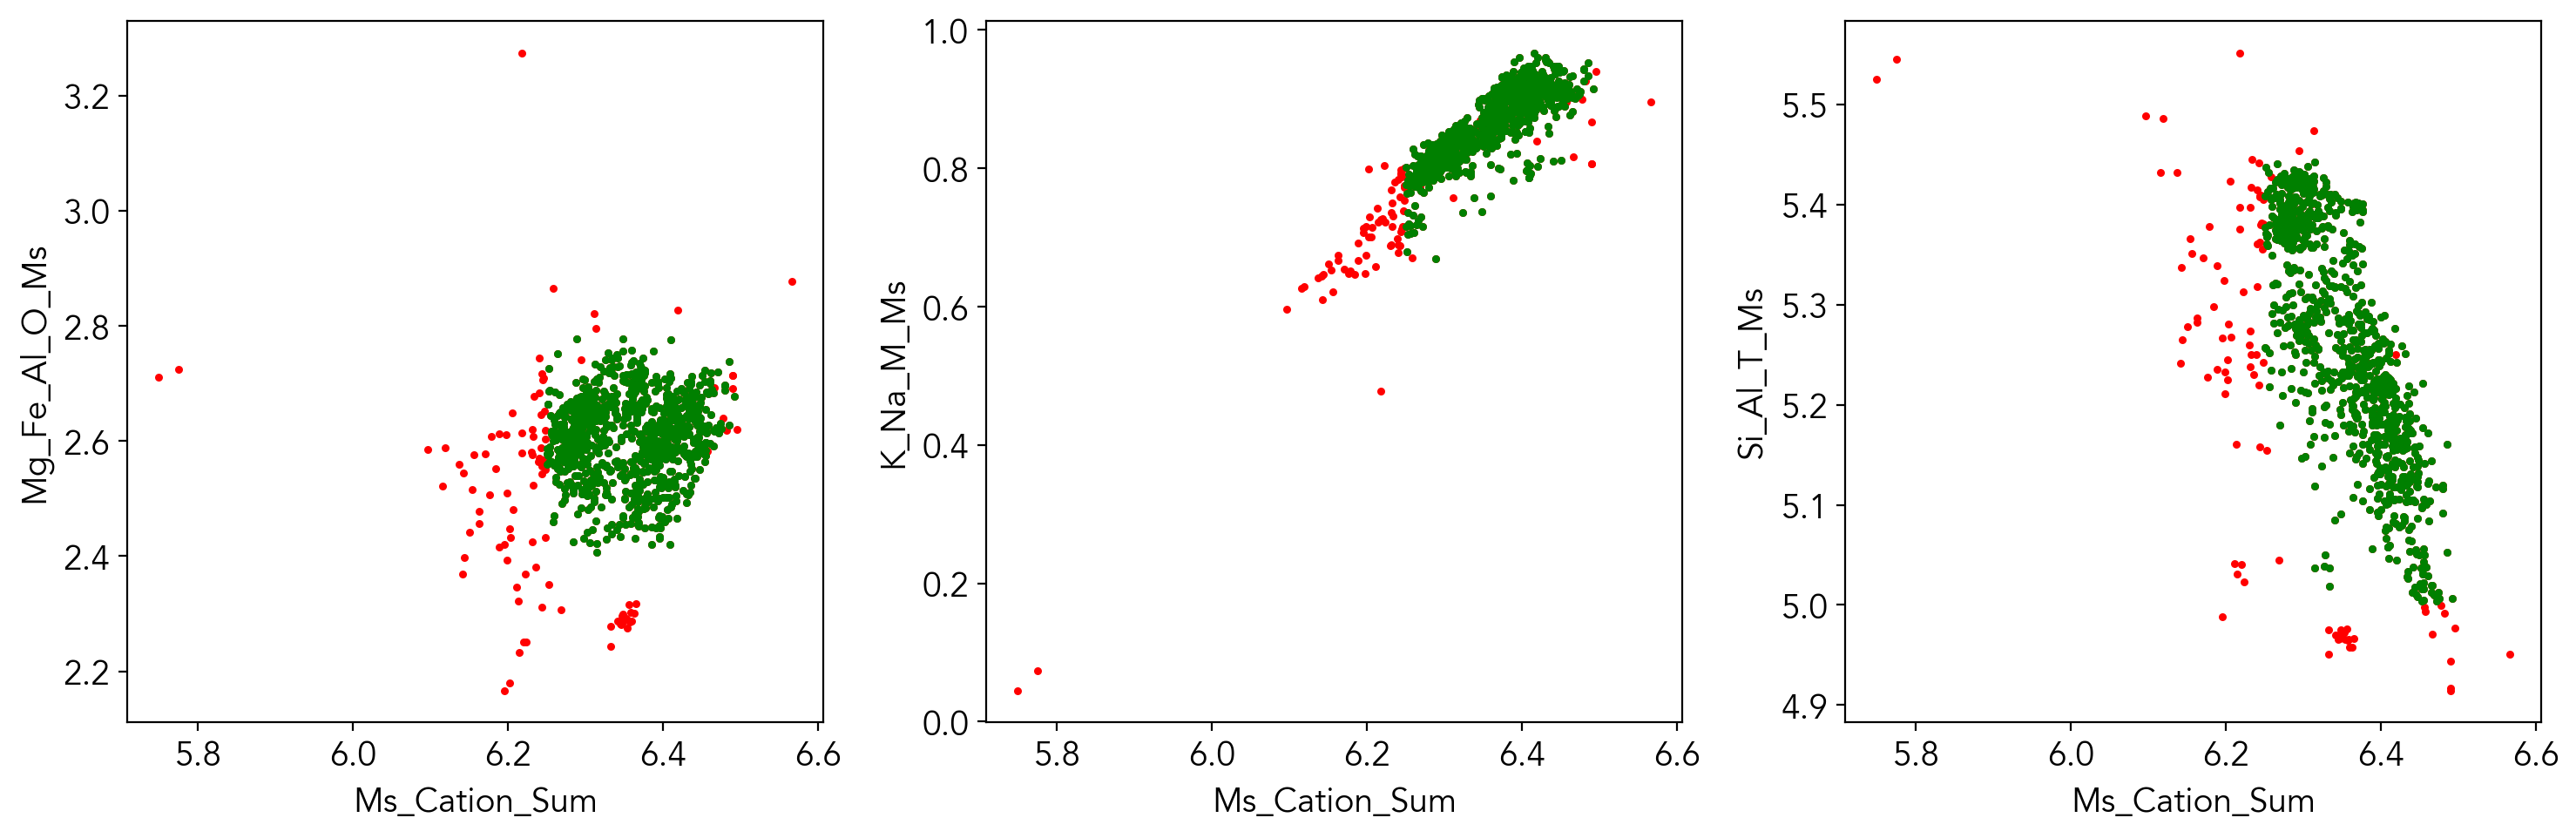

In [16]:
ms_df = min_df_lim[min_df_lim['Mineral'] == 'Muscovite'].rename(columns={c: c+'_Ms' for c in min_df_lim.columns if c not in constants })
ms_comp = mm.calculate_muscovite_components(ms_df, '_Ms')

ms_comp_filt = ms_comp.loc[((ms_comp.Ms_Cation_Sum.between(6.25, 6.50)) & (ms_comp.K_Na_M_Ms.between(0.6, 1.0)) & (ms_comp.Mg_Fe_Al_O_Ms.between(2.4, 2.78)) & (ms_comp.Si_Al_T_Ms.between(5.00, 5.45)))]

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
ax[0].scatter(ms_comp['Ms_Cation_Sum'], ms_comp['Mg_Fe_Al_O_Ms'], s = 5, color = 'r')
ax[0].scatter(ms_comp_filt['Ms_Cation_Sum'], ms_comp_filt['Mg_Fe_Al_O_Ms'], s = 5, color = 'g')
ax[0].set_xlabel('Ms_Cation_Sum')
ax[0].set_ylabel('Mg_Fe_Al_O_Ms')
ax[1].scatter(ms_comp['Ms_Cation_Sum'], ms_comp['K_Na_M_Ms'], s = 5, color = 'r')
ax[1].scatter(ms_comp_filt['Ms_Cation_Sum'], ms_comp_filt['K_Na_M_Ms'], s = 5, color = 'g')
ax[1].set_xlabel('Ms_Cation_Sum')
ax[1].set_ylabel('K_Na_M_Ms')
ax[2].scatter(ms_comp['Ms_Cation_Sum'], ms_comp['Si_Al_T_Ms'], s = 5, color = 'r')
ax[2].scatter(ms_comp_filt['Ms_Cation_Sum'], ms_comp_filt['Si_Al_T_Ms'], s = 5, color = 'g')
ax[2].set_xlabel('Ms_Cation_Sum')
ax[2].set_ylabel('Si_Al_T_Ms')

plt.tight_layout()

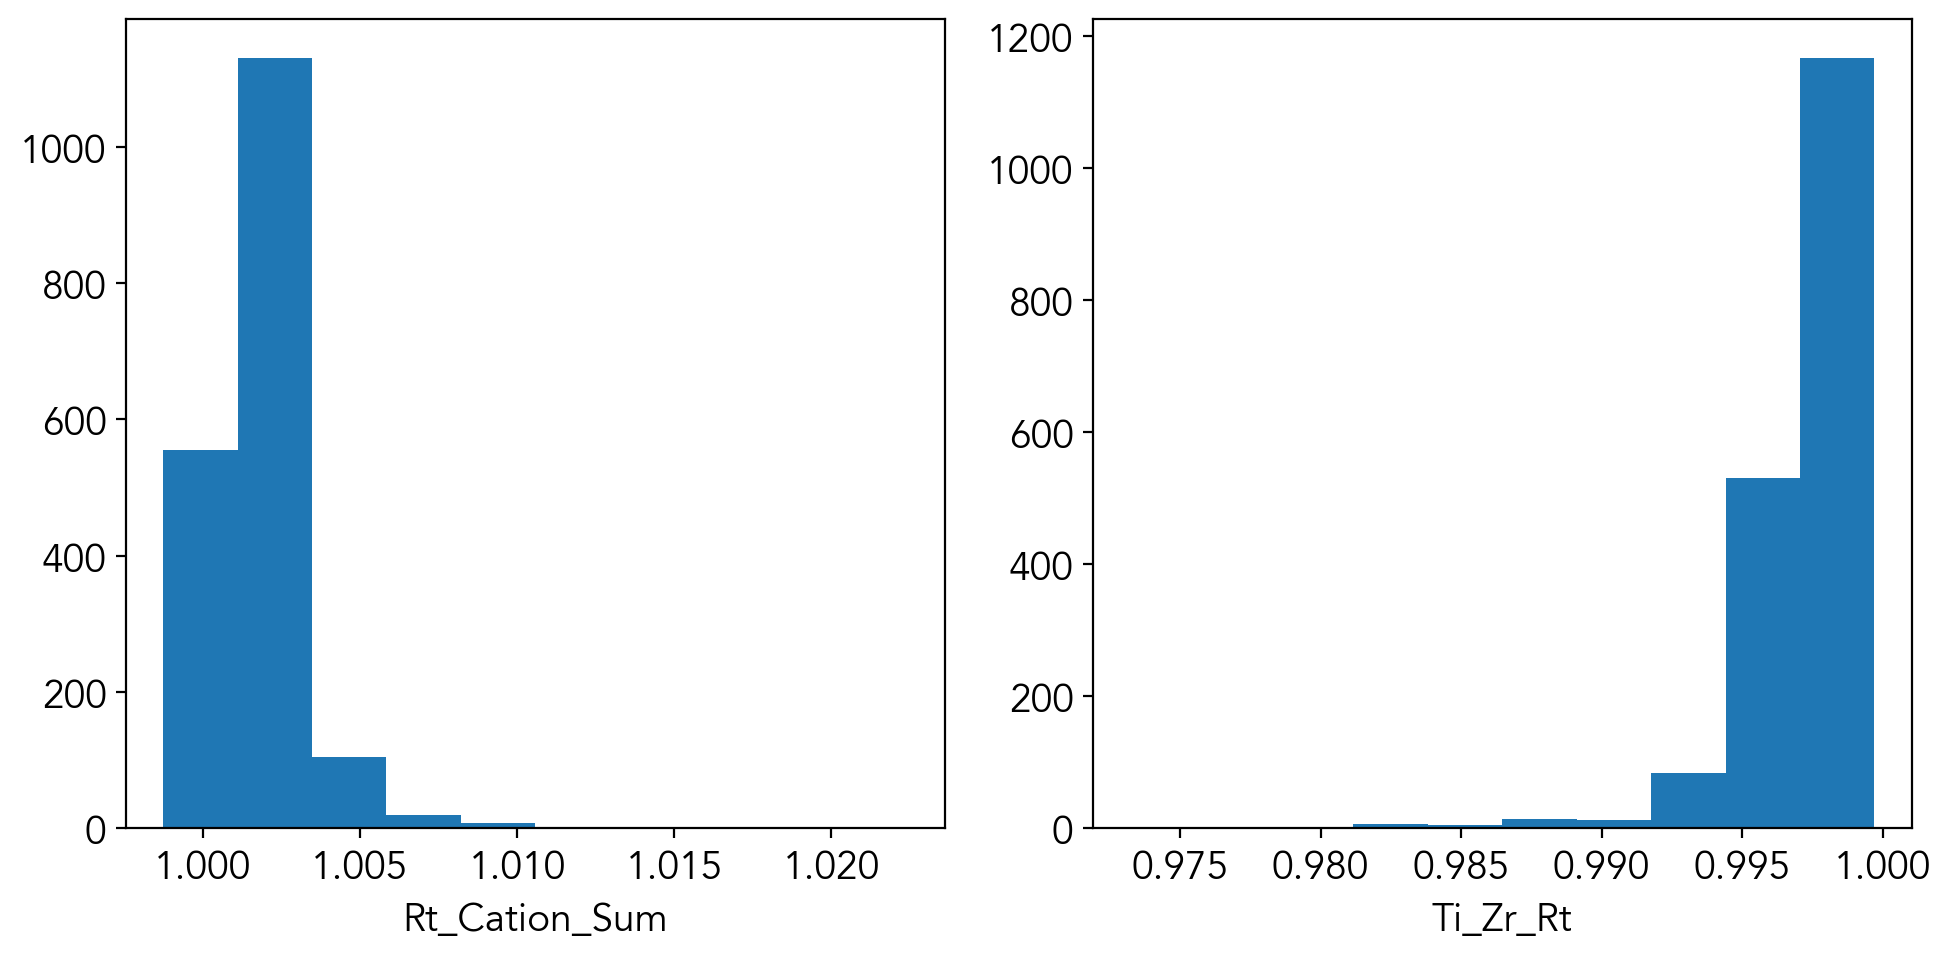

In [17]:
rt_df = min_df_lim[min_df_lim['Mineral'] == 'Rutile'].rename(columns={c: c+'_Rt' for c in min_df_lim.columns if c not in constants })
rt_comp = mm.calculate_rutile_components(rt_df, '_Rt')
rt_comp_filt = rt_comp.loc[((rt_comp.Ti_Zr_Rt.between(0.99, 1.0)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].hist(rt_comp['Rt_Cation_Sum'], bins = 10)
ax[0].set_xlabel('Rt_Cation_Sum')
ax[1].hist(rt_comp['Ti_Zr_Rt'], bins = 10)
ax[1].set_xlabel('Ti_Zr_Rt')
plt.tight_layout()

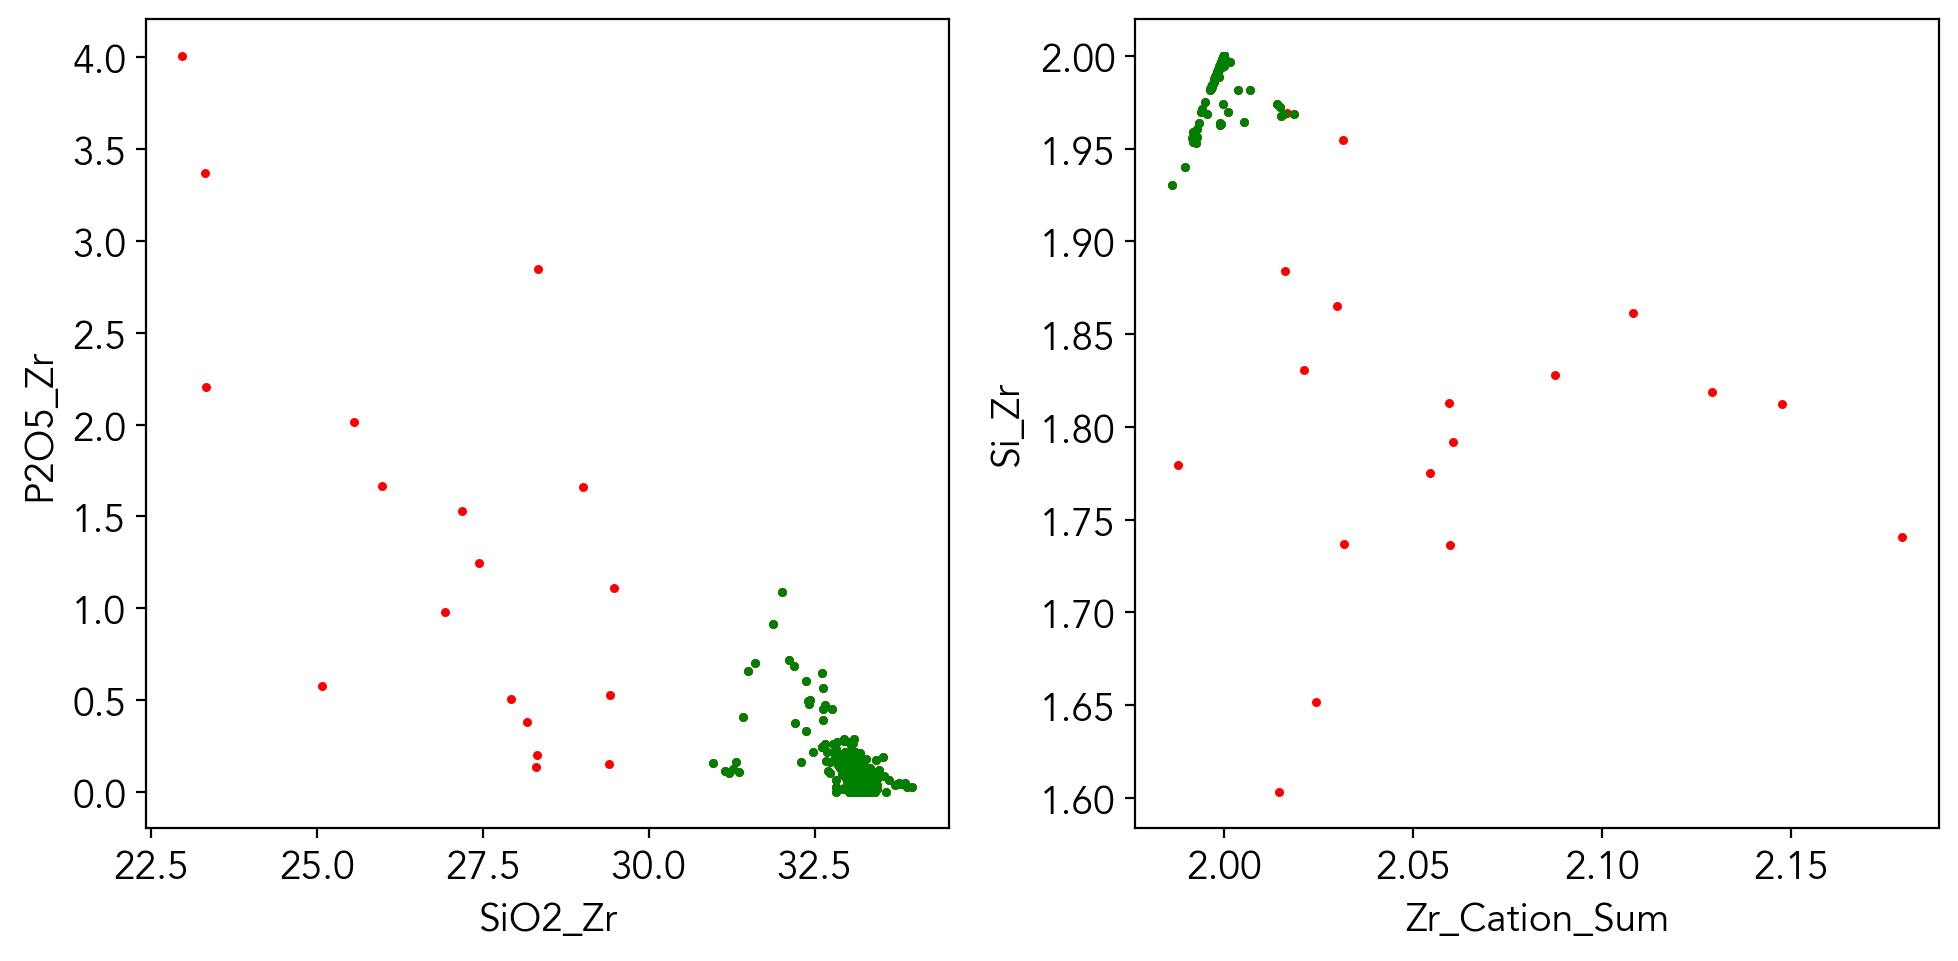

In [18]:
zr_df = min_df_lim[min_df_lim['Mineral'] == 'Zircon'].rename(columns={c: c+'_Zr' for c in min_df_lim.columns if c not in constants })
zr_comp = mm.calculate_zircon_components(zr_df, '_Zr')
zr_comp_filt = zr_comp.loc[((zr_comp.SiO2_Zr.between(30, 35)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(zr_comp['SiO2_Zr'], zr_comp['P2O5_Zr'], s = 5, color = 'r')
ax[0].scatter(zr_comp_filt['SiO2_Zr'], zr_comp_filt['P2O5_Zr'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2_Zr')
ax[0].set_ylabel('P2O5_Zr')

ax[1].scatter(zr_comp['Zr_Cation_Sum'], zr_comp['Si_Zr'], s = 5, color = 'r')
ax[1].scatter(zr_comp_filt['Zr_Cation_Sum'], zr_comp_filt['Si_Zr'], s = 5, color = 'g')
ax[1].set_xlabel('Zr_Cation_Sum')
ax[1].set_ylabel('Si_Zr')
plt.tight_layout()

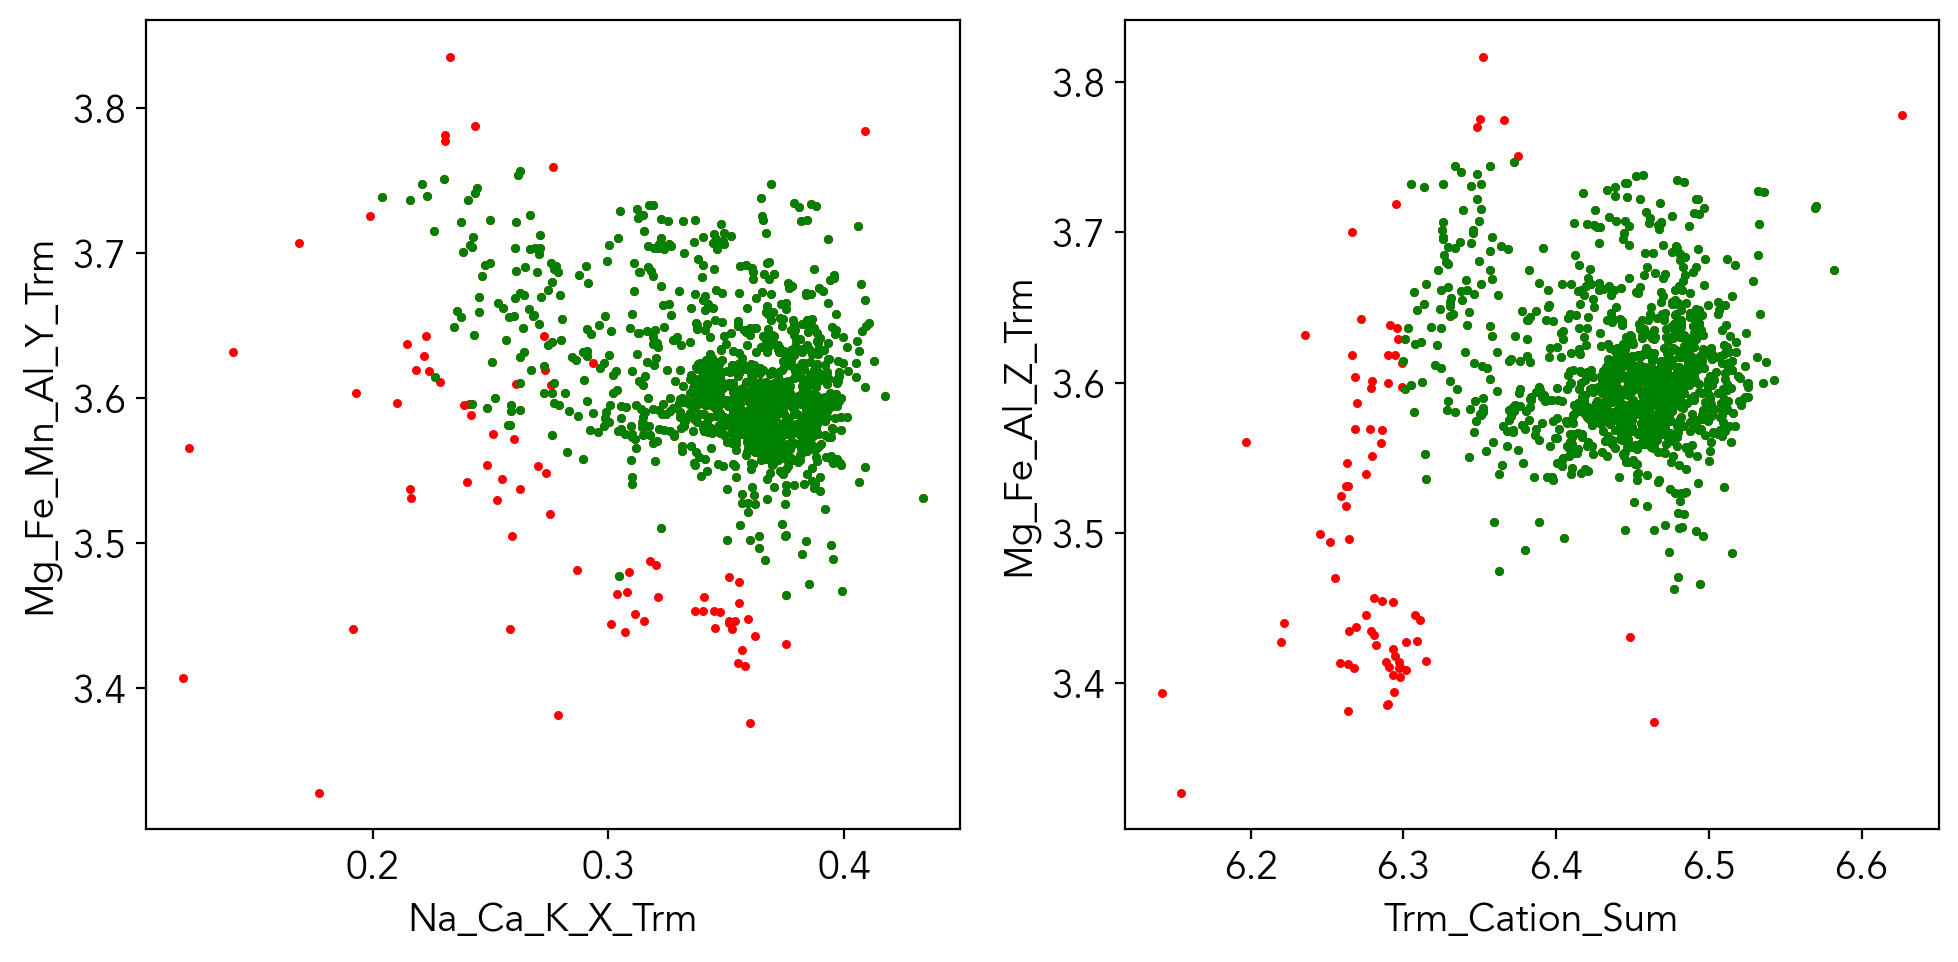

In [19]:
trm_df = min_df_lim[min_df_lim['Mineral'] == 'Tourmaline'].rename(columns={c: c+'_Trm' for c in min_df_lim.columns if c not in constants })
trm_comp = mm.calculate_tourmaline_components(trm_df, '_Trm')
trm_comp_filt = trm_comp.loc[((trm_comp.Trm_Cation_Sum.between(6.3, 6.6)) & (trm_comp.Mg_Fe_Al_Z_Trm.between(3.45, 3.75)))]

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(trm_comp['Na_Ca_K_X_Trm'], trm_comp['Mg_Fe_Mn_Al_Y_Trm'], s = 5, color = 'r')
ax[0].scatter(trm_comp_filt['Na_Ca_K_X_Trm'], trm_comp_filt['Mg_Fe_Mn_Al_Y_Trm'], s = 5, color = 'g')
ax[0].set_xlabel('Na_Ca_K_X_Trm')
ax[0].set_ylabel('Mg_Fe_Mn_Al_Y_Trm')

ax[1].scatter(trm_comp['Trm_Cation_Sum'], trm_comp['Mg_Fe_Al_Z_Trm'], s = 5, color = 'r')
ax[1].scatter(trm_comp_filt['Trm_Cation_Sum'], trm_comp_filt['Mg_Fe_Al_Z_Trm'], s = 5, color = 'g')
ax[1].set_xlabel('Trm_Cation_Sum')
ax[1].set_ylabel('Mg_Fe_Al_Z_Trm')
plt.tight_layout()

In [20]:
oxideslab = ['Sample Name', 'SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'NiO', 'Mineral']

new_column_names = {'Sample Name': 'Sample Name', 'SiO2': 'SiO2', 'TiO2': 'TiO2', 'Al2O3': 'Al2O3', 'FeOt': 'FeOt', 'MnO': 'MnO', 'MgO': 'MgO', 'CaO': 'CaO', 'Na2O': 'Na2O', 'K2O': 'K2O', 'P2O5': 'P2O5', 'Cr2O3': 'Cr2O3', 'NiO': 'NiO'}
amp_comp_filt = amp_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
ap_comp_filt = ap_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
bt_comp_filt = bt_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
cpx_comp_filt = cpx_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
gt_comp_filt = gt_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
ksp_comp_filt = ksp_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
ms_comp_filt = ms_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
ol_comp_filt = ol_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
opx_comp_filt = opx_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
ox_comp_filt = ox_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
plag_comp_filt = plag_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
qz_comp_filt = qz_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
rt_comp_filt = rt_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
sp_comp_filt = sp_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
trm_comp_filt = trm_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))
zr_comp_filt = zr_comp_filt.rename(columns=lambda x: next((new_column_names[k] for k in new_column_names if k in x), x))

In [21]:
min_comp_filt = pd.concat([amp_comp_filt[oxideslab], ap_comp_filt[oxideslab], bt_comp_filt[oxideslab], cpx_comp_filt[oxideslab], gt_comp_filt[oxideslab], ksp_comp_filt[oxideslab], ms_comp_filt[oxideslab], ol_comp_filt[oxideslab], opx_comp_filt[oxideslab], ox_comp_filt[oxideslab], plag_comp_filt[oxideslab], qz_comp_filt[oxideslab], rt_comp_filt[oxideslab], sp_comp_filt[oxideslab], trm_comp_filt[oxideslab], zr_comp_filt[oxideslab]], axis = 0)

min_comp_filt.to_csv('TrainingData/mindf_filt.csv', index = False)